<a href="https://colab.research.google.com/github/AntonDozhdikov/Demography_migration/blob/main/600_9_MARL_FINAL_EN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
"""
Reinforcement Learning Multi-Agent System for Modeling Demographic Policies in Russian Regions.
CHANGES:
1. The number of training epochs has been increased to 600 for all nine experiments.
2. Data from the year 2000 onward is utilized.
3. Experiment 0 (MADDPG-EVO-0) remains unchanged.
4. Modifications have been introduced into the remaining experiments to enhance stability and incorporate real-world data.
"""

# Import libraries for numerical computations and data processing
import numpy as np
import pandas as pd
# Import PyTorch libraries for neural network construction and training
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# Import data structures and random number generation module
from collections import defaultdict, deque
import random
# Import modules for JSON handling and plotting
import json
import matplotlib.pyplot as plt
import seaborn as sns
# Import datetime module
from datetime import datetime
# Import warning management module
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Configure matplotlib for proper rendering of non-ASCII text
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# --- BLOCK 1: Processing and Generation of Demographic Data ---
class DemographicDataProcessor:
    """Processor for demographic data based on real regional statistics."""
    def __init__(self, real_data_path, crisis_scenarios_path):
        """Initialize the data processor."""
        self.df = pd.read_csv(real_data_path)
        # Load crisis scenarios from JSON file
        with open(crisis_scenarios_path, 'r') as f:
            self.crisis_scenarios = json.load(f)
        self.preprocess_data()

    def preprocess_data(self):
        """Preprocess real data for simulation."""
        # Fill missing values via forward and backward filling
        self.df = self.df.fillna(method='ffill').fillna(method='bfill')
        # Compute additional indicators where data is absent
        self.df.loc[self.df['natural_increase_rate'].isna(), 'natural_increase_rate'] = \
            self.df['birth_rate'] - self.df['death_rate']
        # Normalize statistics by region
        self.region_stats = {}
        for region in self.df['region_name'].unique():
            region_data = self.df[self.df['region_name'] == region]
            # Compute statistical metrics per region
            self.region_stats[region] = {
                'birth_rate_mean': region_data['birth_rate'].mean(),
                'birth_rate_std': region_data['birth_rate'].std(),
                'death_rate_mean': region_data['death_rate'].mean(),
                'death_rate_std': region_data['death_rate'].std(),
                'migration_mean': region_data['migration_balance'].mean(),
                'migration_std': region_data['migration_balance'].std(),
                'gdp_mean': region_data['gdp_per_capita'].mean(),
                'gdp_std': region_data['gdp_per_capita'].std(),
                'unemployment_mean': region_data['unemployment_rate'].mean(),
                'unemployment_std': region_data['unemployment_rate'].std(),
                'population_trend': self._calculate_trend(region_data['population']),
                'region_id': region_data['region_id'].iloc[0]
            }

    def _calculate_trend(self, series):
        """Compute the linear trend of a time series."""
        series = series.dropna()
        if len(series) < 2:
            return 0
        x = np.arange(len(series))
        z = np.polyfit(x, series, 1)
        return z[0]

    def apply_crisis_impact(self, base_values, crisis_scenario, year, crisis_start_year):
        """Apply crisis impact on demographic indicators."""
        crisis_duration = year - crisis_start_year + 1
        max_duration = crisis_scenario['end_year'] - crisis_scenario['start_year'] + 1
        # Crisis intensity decays over time
        intensity = max(0, 1 - (crisis_duration - 1) / max_duration)
        impacts = crisis_scenario['demographic_impacts']
        # Compute impacts on each indicator
        birth_rate_impact = impacts['birth_rate_change'] * intensity
        death_rate_impact = impacts['death_rate_change'] * intensity
        migration_impact = impacts['migration_change'] * intensity
        economic_impact = impacts['economic_impact'] * intensity
        modified_values = base_values.copy()
        # Apply impacts to indicators
        modified_values['birth_rate'] *= (1 + birth_rate_impact)
        modified_values['death_rate'] *= (1 + death_rate_impact)
        modified_values['migration_balance'] *= (1 + migration_impact)
        modified_values['gdp_per_capita'] *= (1 + economic_impact)
        modified_values['unemployment_rate'] *= (1 - economic_impact * 0.5)
        return modified_values

    def generate_training_data(self, years, regions, apply_crisis=True):
        """Generate training data based on real-world observations."""
        training_data = []
        for year in years:
            for region in regions:
                if region not in self.region_stats:
                    continue
                # Retrieve real data if available
                real_data = self.df[(self.df['region_name'] == region) & (self.df['year'] == year)]
                if len(real_data) > 0:
                    # Use observed data
                    base_values = {
                        'region_id': real_data['region_id'].iloc[0],
                        'region_name': region,
                        'year': year,
                        'birth_rate': real_data['birth_rate'].iloc[0],
                        'death_rate': real_data['death_rate'].iloc[0],
                        'migration_balance': real_data['migration_balance'].iloc[0],
                        'gdp_per_capita': real_data['gdp_per_capita'].iloc[0],
                        'unemployment_rate': real_data['unemployment_rate'].iloc[0],
                        'population': real_data['population'].iloc[0],
                        'average_wage': real_data['average_wage'].iloc[0]
                    }
                else:
                    # Generate synthetic data using statistical profiles
                    stats = self.region_stats[region]
                    base_values = {
                        'region_id': stats['region_id'],
                        'region_name': region,
                        'year': year,
                        'birth_rate': max(0, np.random.normal(stats['birth_rate_mean'], stats['birth_rate_std'])),
                        'death_rate': max(0, np.random.normal(stats['death_rate_mean'], stats['death_rate_std'])),
                        'migration_balance': np.random.normal(stats['migration_mean'], stats['migration_std']),
                        'gdp_per_capita': max(0, np.random.normal(stats['gdp_mean'], stats['gdp_std'])),
                        'unemployment_rate': max(0, min(100, np.random.normal(stats['unemployment_mean'], stats['unemployment_std'])))
                    }
                # Apply crisis scenarios if enabled
                if apply_crisis:
                    for scenario in self.crisis_scenarios:
                        if scenario['start_year'] <= year <= scenario['end_year']:
                            base_values = self.apply_crisis_impact(
                                base_values, scenario, year, scenario['start_year']
                            )
                # Compute derived indicators
                base_values['natural_increase_rate'] = base_values['birth_rate'] - base_values['death_rate']
                # Estimate population based on trend
                if 'population' not in base_values:
                    base_population = 1000000 + stats['population_trend'] * (year - 2010)
                    base_values['population'] = max(0, int(base_population +
                        (base_values['natural_increase_rate'] + base_values['migration_balance']/1000) * 1000))
                # Estimate average wage
                if 'average_wage' not in base_values or pd.isna(base_values['average_wage']):
                    base_values['average_wage'] = max(0, base_values['gdp_per_capita'] * 0.03 *
                        (1 - base_values['unemployment_rate']/100))
                training_data.append(base_values)
        return pd.DataFrame(training_data)

In [42]:
# --- BLOCK 2: Definition of the Learning Environment (DemographicEnvironment) ---
class DemographicEnvironment:
    """Multi-agent environment for demographic modeling."""
    def __init__(self, data, n_regions=8, max_steps=50):
        self.data = data
        # Obtain first n_regions unique region names
        self.regions = data['region_name'].unique()[:n_regions]
        self.n_regions = len(self.regions)
        self.max_steps = max_steps
        self.current_step = 0
        # State and action space dimensions
        self.state_dim = 8  # Core demographic indicators
        self.action_dim = 4  # Policy actions
        # Stability history for each region (used in enhanced metric)
        self.stability_history = {region: deque(maxlen=20) for region in self.regions}
        self.reset()

    def reset(self):
        """Reset environment to initial state."""
        self.current_step = 0
        self.states = {}
        self.histories = {region: [] for region in self.regions}
        # Initialize state for all regions
        for i, region in enumerate(self.regions):
            region_data = self.data[self.data['region_name'] == region].iloc[0]
            self.states[region] = self._normalize_state(region_data)
        return self.get_observations()

    def _normalize_state(self, region_data):
        """Normalize regional state variables."""
        return np.array([
            region_data['birth_rate'] / 20.0,  # Normalize birth rate
            region_data['death_rate'] / 30.0,  # Normalize death rate
            region_data['natural_increase_rate'] / 10.0,  # Normalize natural increase
            min(region_data['migration_balance'] / 100000.0, 1.0),  # Normalize migration balance
            region_data['gdp_per_capita'] / 2000000.0,  # Normalize GDP per capita
            region_data['unemployment_rate'] / 100.0,  # Normalize unemployment rate
            region_data['population'] / 10000000.0,  # Normalize population
            region_data['average_wage'] / 200000.0  # Normalize average wage
        ])

    def get_observations(self):
        """Obtain observations for all agents."""
        observations = {}
        for region in self.regions:
            # Local observation (current region state)
            obs = self.states[region].copy()
            # Aggregate states of other regions
            other_states = [self.states[r] for r in self.regions if r != region]
            # Append averaged information from other regions
            if other_states:
                avg_other = np.mean(other_states, axis=0)
                obs = np.concatenate([obs, avg_other])
            else:
                obs = np.concatenate([obs, np.zeros(self.state_dim)])
            observations[region] = obs
        return observations

    def step(self, actions):
        """Execute one step in the environment."""
        rewards = {}
        for region in self.regions:
            if region in actions:
                action = actions[region]
                old_state = self.states[region].copy()
                # Update region state based on policy action
                self.states[region] = self._apply_policy_action(self.states[region], action)
                # Compute reward for state transition
                rewards[region] = self._calculate_reward(old_state, self.states[region])
                # Record historical trajectory
                self.histories[region].append({
                    'step': self.current_step,
                    'state': old_state.copy(),
                    'action': action.copy(),
                    'reward': rewards[region]
                })
        self.current_step += 1
        done = self.current_step >= self.max_steps
        return self.get_observations(), rewards, done, {}

    def _apply_policy_action(self, state, action):
        """Apply policy actions to the regional state."""
        new_state = state.copy()
        # action[0] - maternal capital (affects birth rate)
        # action[1] - healthcare investment (affects death rate)
        # action[2] - migration policy (affects migration balance)
        # action[3] - economic incentives (affects GDP and unemployment)
        birth_rate_change = action[0] * 0.1
        death_rate_change = -action[1] * 0.05
        migration_change = action[2] * 0.05
        economic_change = action[3] * 0.02
        # Update indicators with constraints
        new_state[0] = max(0, new_state[0] + birth_rate_change)  # birth rate
        new_state[1] = max(0, new_state[1] + death_rate_change)  # death rate
        new_state[2] = new_state[0] - new_state[1]  # natural increase
        new_state[3] = new_state[3] + migration_change  # migration balance
        new_state[4] = max(0, new_state[4] + economic_change)  # GDP per capita
        new_state[5] = max(0, min(1, new_state[5] - economic_change * 0.5))  # unemployment
        # Update population
        population_change = (new_state[2] + new_state[3]) * 0.01
        new_state[6] = max(0, new_state[6] + population_change)  # population
        # Update average wage
        new_state[7] = new_state[4] * 0.1 * (1 - new_state[5])  # average wage
        return new_state

    def _calculate_reward(self, old_state, new_state):
        """Compute reward based on improvement in demographic indicators."""
        # Positive changes with weights
        birth_rate_improvement = (new_state[0] - old_state[0]) * 10
        death_rate_improvement = (old_state[1] - new_state[1]) * 10
        natural_increase_improvement = (new_state[2] - old_state[2]) * 15
        migration_improvement = (new_state[3] - old_state[3]) * 5
        gdp_improvement = (new_state[4] - old_state[4]) * 5
        unemployment_improvement = (old_state[5] - new_state[5]) * 5
        # Enhanced penalty for population instability
        population_stability = -abs(new_state[6] - old_state[6]) * 5
        # Sum components
        total_reward = (birth_rate_improvement + death_rate_improvement +
                       natural_increase_improvement + migration_improvement +
                       gdp_improvement + unemployment_improvement + population_stability)
        return total_reward

In [43]:
# --- BLOCK 3: Definition of Neural Networks for Agents ---
class ActorNetwork(nn.Module):
    """Actor network for MADDPG."""
    def __init__(self, input_dim, action_dim, hidden_dim=256):
        super(ActorNetwork, self).__init__()
        # Fully connected layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))  # Actions bounded between -1 and 1
        return x

class CriticNetwork(nn.Module):
    """Critic network for MADDPG."""
    def __init__(self, state_dim, action_dim, n_agents, hidden_dim=256):
        super(CriticNetwork, self).__init__()
        # Total input dimension: concatenated states and actions of all agents
        total_input_dim = state_dim * n_agents + action_dim * n_agents
        self.fc1 = nn.Linear(total_input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, states, actions):
        x = torch.cat([states, actions], dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# --- NEW NETWORKS AND AGENTS FOR ADDITIONAL EXPERIMENTS ---
class ActorNetworkPPO(nn.Module):
    """Actor network for MAPPO (outputting distribution parameters)."""
    def __init__(self, input_dim, action_dim, hidden_dim=256):
        super(ActorNetworkPPO, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, action_dim)
        self.fc_log_std = nn.Parameter(torch.zeros(1, action_dim))  # Log standard deviation
        self.dropout = nn.Dropout(0.1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        mean = torch.tanh(self.fc_mean(x))  # Mean bounded between -1 and 1
        return mean

    def get_action_log_prob(self, state):
        mean = self.forward(state)
        log_std = self.fc_log_std.expand_as(mean)
        std = torch.exp(log_std)
        dist = torch.distributions.Normal(mean, std)
        action_raw = dist.rsample()  # Reparameterization trick
        action = torch.tanh(action_raw)  # Clamp actions to [-1, 1]
        # Correct density for tanh transformation
        log_prob = dist.log_prob(action_raw) - torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        return action, log_prob

    def get_log_prob_entropy(self, state, action):
        mean = self.forward(state)
        log_std = self.fc_log_std.expand_as(mean)
        std = torch.exp(log_std)
        dist = torch.distributions.Normal(mean, std)
        # Invert tanh to compute log_prob
        u = torch.atanh(action.clamp(-0.999, 0.999))  # Avoid numerical inf
        log_prob = dist.log_prob(u) - torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        entropy = dist.entropy().sum(dim=-1, keepdim=True)
        return log_prob, entropy

class CriticNetworkPPO(nn.Module):
    """Critic network for MAPPO."""
    def __init__(self, input_dim, hidden_dim=256):
        # input_dim should be env.state_dim * 2 * n_agents (global state)
        super(CriticNetworkPPO, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class CriticNetworkTD3(nn.Module):
    """Critic network for MATD3 (dual Q-networks)."""
    def __init__(self, state_dim, action_dim, n_agents, hidden_dim=256):
        # state_dim here should be env.state_dim * 2
        super(CriticNetworkTD3, self).__init__()
        total_input_dim = state_dim * n_agents + action_dim * n_agents
        # Q1
        self.fc1_q1 = nn.Linear(total_input_dim, hidden_dim)
        self.fc2_q1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3_q1 = nn.Linear(hidden_dim, 1)
        # Q2
        self.fc1_q2 = nn.Linear(total_input_dim, hidden_dim)
        self.fc2_q2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3_q2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, states, actions):
        x = torch.cat([states, actions], dim=1)
        # Q1 forward
        q1 = F.relu(self.fc1_q1(x))
        q1 = self.dropout(q1)
        q1 = F.relu(self.fc2_q1(q1))
        q1 = self.fc3_q1(q1)
        # Q2 forward
        q2 = F.relu(self.fc1_q2(x))
        q2 = self.dropout(q2)
        q2 = F.relu(self.fc2_q2(q2))
        q2 = self.fc3_q2(q2)
        return q1, q2

    def Q1(self, states, actions):
        x = torch.cat([states, actions], dim=1)
        q1 = F.relu(self.fc1_q1(x))
        q1 = self.dropout(q1)
        q1 = F.relu(self.fc2_q1(q1))
        q1 = self.fc3_q1(q1)
        return q1

class CriticNetworkAC(nn.Module):
    """Critic network for MAAC (simplified version without attention)."""
    def __init__(self, state_dim, action_dim, n_agents, hidden_dim=256):
        # state_dim here should be env.state_dim * 2
        super(CriticNetworkAC, self).__init__()
        # Simplified version uses same structure as MADDPG
        total_input_dim = state_dim * n_agents + action_dim * n_agents
        self.fc1 = nn.Linear(total_input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, states, actions):
        x = torch.cat([states, actions], dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [44]:
# --- BLOCK 4: Definition of Agents (MADDPG, MAPPO, MATD3, MAAC) ---
class MADDPGAgent:
    """MADDPG Agent."""
    def __init__(self, agent_id, state_dim, action_dim, n_agents, lr_actor=1e-4, lr_critic=1e-3):
        self.agent_id = agent_id
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.n_agents = n_agents
        # Actor networks (main and target)
        self.actor = ActorNetwork(state_dim, action_dim)
        self.actor_target = ActorNetwork(state_dim, action_dim)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        # Critic networks (main and target)
        self.critic = CriticNetwork(state_dim, action_dim, n_agents)
        self.critic_target = CriticNetwork(state_dim, action_dim, n_agents)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)
        # Initialize target networks by copying weights
        self.hard_update(self.actor_target, self.actor)
        self.hard_update(self.critic_target, self.critic)
        # Training parameters
        self.gamma = 0.95  # Discount factor
        self.tau = 0.02    # Soft update parameter

    def act(self, state, noise_scale=0.1):
        """Select action with exploration noise."""
        state = torch.FloatTensor(state).unsqueeze(0)
        action = self.actor(state).squeeze(0).detach().numpy()
        # Add noise for exploration
        noise = np.random.normal(0, noise_scale, size=action.shape)
        action = np.clip(action + noise, -1, 1)
        return action

    def hard_update(self, target, source):
        """Hard update of target network parameters."""
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

    def soft_update(self, target, source):
        """Soft update of target network parameters."""
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * self.tau)

class MAPPOAgent:
    """MAPPO Agent."""
    def __init__(self, agent_id, state_dim, action_dim, n_agents, lr_actor=1e-4, lr_critic=1e-3):
        # state_dim here should be env.state_dim * 2 (local + global)
        self.agent_id = agent_id
        self.state_dim = state_dim  # 16
        self.action_dim = action_dim
        self.n_agents = n_agents
        # Actor receives local + global state (16)
        self.actor = ActorNetworkPPO(state_dim, action_dim)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        # Critic receives global state (16 * 8 = 128)
        self.critic = CriticNetworkPPO(state_dim * n_agents)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.gamma = 0.95
        self.eps_clip = 0.2  # PPO clipping parameter

    def act(self, state):
        """Select action deterministically during inference."""
        # state already has dimension env.state_dim * 2
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action, log_prob = self.actor.get_action_log_prob(state)
        return action.squeeze(0).numpy(), log_prob.squeeze(0).numpy()

class MATD3Agent:
    """MATD3 Agent."""
    def __init__(self, agent_id, state_dim, action_dim, n_agents, lr_actor=1e-4, lr_critic=1e-3):
        # state_dim here should be env.state_dim * 2
        self.agent_id = agent_id
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.n_agents = n_agents
        self.train_step = 0
        self.policy_delay = 2  # Policy update delay
        self.actor = ActorNetwork(state_dim, action_dim)
        self.actor_target = ActorNetwork(state_dim, action_dim)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic = CriticNetworkTD3(state_dim, action_dim, n_agents)
        self.critic_target = CriticNetworkTD3(state_dim, action_dim, n_agents)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.hard_update(self.actor_target, self.actor)
        self.hard_update(self.critic_target, self.critic)
        self.gamma = 0.95
        self.tau = 0.02

    def act(self, state, noise_scale=0.1):
        """Select action with exploration noise."""
        # state already has dimension env.state_dim * 2
        state = torch.FloatTensor(state).unsqueeze(0)
        action = self.actor(state).squeeze(0).detach().numpy()
        noise = np.random.normal(0, noise_scale, size=action.shape)
        action = np.clip(action + noise, -1, 1)
        return action

    def hard_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

    def soft_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * self.tau)

class MAACAgent:
    """MAAC Agent (simplified version without attention)."""
    def __init__(self, agent_id, state_dim, action_dim, n_agents, lr_actor=1e-4, lr_critic=1e-3):
        # state_dim here should be env.state_dim * 2
        self.agent_id = agent_id
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.n_agents = n_agents
        self.actor = ActorNetwork(state_dim, action_dim)
        self.actor_target = ActorNetwork(state_dim, action_dim)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic = CriticNetworkAC(state_dim, action_dim, n_agents)
        self.critic_target = CriticNetworkAC(state_dim, action_dim, n_agents)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.hard_update(self.actor_target, self.actor)
        self.hard_update(self.critic_target, self.critic)
        self.gamma = 0.95
        self.tau = 0.02

    def act(self, state, noise_scale=0.1):
        """Select action with exploration noise."""
        # state already has dimension env.state_dim * 2
        state = torch.FloatTensor(state).unsqueeze(0)
        action = self.actor(state).squeeze(0).detach().numpy()
        noise = np.random.normal(0, noise_scale, size=action.shape)
        action = np.clip(action + noise, -1, 1)
        return action

    def hard_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

    def soft_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * self.tau)

In [45]:
# --- BLOCK 5: Evolutionary Booster (EvolutionaryBooster) ---
class EvolutionaryBooster:
    """Evolutionary booster for optimizing MARL agents."""
    def __init__(self, population_size=20, mutation_rate=0.1, crossover_rate=0.7):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.population = []
        self.fitness_history = []

    def initialize_population(self, agent_template):
        """Initialize population of agents."""
        self.population = []
        for _ in range(self.population_size):
            agent_copy = self._copy_agent(agent_template)
            self._mutate_agent(agent_copy, mutation_strength=0.3)
            self.population.append(agent_copy)

    def _copy_agent(self, agent):
        """Create a deep copy of an agent."""
        # Determine agent type and instantiate corresponding class
        if isinstance(agent, MADDPGAgent):
            new_agent = MADDPGAgent(agent.agent_id, agent.state_dim, agent.action_dim, agent.n_agents)
        elif isinstance(agent, MAPPOAgent):
            new_agent = MAPPOAgent(agent.agent_id, agent.state_dim, agent.action_dim, agent.n_agents)
        elif isinstance(agent, MATD3Agent):
            new_agent = MATD3Agent(agent.agent_id, agent.state_dim, agent.action_dim, agent.n_agents)
        elif isinstance(agent, MAACAgent):
            new_agent = MAACAgent(agent.agent_id, agent.state_dim, agent.action_dim, agent.n_agents)
        else:
            raise ValueError(f"Unsupported agent type: {type(agent)}")
        # Copy network weights
        if hasattr(agent, 'actor'):
            new_agent.actor.load_state_dict(agent.actor.state_dict())
        if hasattr(agent, 'critic'):
            new_agent.critic.load_state_dict(agent.critic.state_dict())
        if hasattr(agent, 'actor_target'):
            new_agent.actor_target.load_state_dict(agent.actor_target.state_dict())
        if hasattr(agent, 'critic_target'):
            new_agent.critic_target.load_state_dict(agent.critic_target.state_dict())
        return new_agent

    def _mutate_agent(self, agent, mutation_strength=0.1):
        """Mutate agent parameters."""
        # Mutate actor network parameters
        if hasattr(agent, 'actor'):
            for param in agent.actor.parameters():
                if np.random.random() < self.mutation_rate:
                    noise = torch.randn_like(param) * mutation_strength
                    param.data += noise
        # Mutate critic network parameters
        if hasattr(agent, 'critic'):
            for param in agent.critic.parameters():
                if np.random.random() < self.mutation_rate:
                    noise = torch.randn_like(param) * mutation_strength
                    param.data += noise

    def _crossover_agents(self, parent1, parent2):
        """Crossover two agents."""
        child1 = self._copy_agent(parent1)
        child2 = self._copy_agent(parent2)
        # Crossover actor parameters
        if hasattr(parent1, 'actor') and hasattr(parent2, 'actor'):
            for p1, p2, c1, c2 in zip(parent1.actor.parameters(), parent2.actor.parameters(),
                                     child1.actor.parameters(), child2.actor.parameters()):
                if np.random.random() < self.crossover_rate:
                    mask = torch.rand_like(p1) > 0.5
                    c1.data = torch.where(mask, p1.data, p2.data)
                    c2.data = torch.where(mask, p2.data, p1.data)
        # Crossover critic parameters
        if hasattr(parent1, 'critic') and hasattr(parent2, 'critic'):
            for p1, p2, c1, c2 in zip(parent1.critic.parameters(), parent2.critic.parameters(),
                                     child1.critic.parameters(), child2.critic.parameters()):
                if np.random.random() < self.crossover_rate:
                    mask = torch.rand_like(p1) > 0.5
                    c1.data = torch.where(mask, p1.data, p2.data)
                    c2.data = torch.where(mask, p2.data, p1.data)
        return child1, child2

    def evolve_population(self, fitness_scores):
        """Evolve population based on fitness scores."""
        # Sort agents by fitness
        population_fitness = list(zip(self.population, fitness_scores))
        population_fitness.sort(key=lambda x: x[1], reverse=True)
        # Select elite individuals
        elite_size = self.population_size // 4
        elite = [agent for agent, _ in population_fitness[:elite_size]]
        # Generate new population
        new_population = elite.copy()
        while len(new_population) < self.population_size:
            parent1 = self._tournament_selection(population_fitness)
            parent2 = self._tournament_selection(population_fitness)
            if np.random.random() < self.crossover_rate:
                child1, child2 = self._crossover_agents(parent1, parent2)
                self._mutate_agent(child1)
                self._mutate_agent(child2)
                new_population.extend([child1, child2])
            else:
                child = self._copy_agent(parent1)
                self._mutate_agent(child)
                new_population.append(child)
        # Trim and update population
        self.population = new_population[:self.population_size]
        # Record fitness history
        self.fitness_history.append(max(fitness_scores))
        return self.population[0]  # Return best agent

    def _tournament_selection(self, population_fitness, tournament_size=3):
        """Tournament selection of parent."""
        tournament = random.sample(population_fitness, min(tournament_size, len(population_fitness)))
        return max(tournament, key=lambda x: x[1])[0]

In [46]:
# --- BLOCK 6: Experiment Logger (ExperimentLogger) ---
class ExperimentLogger:
    """Logger for recording and visualizing experimental results."""
    def __init__(self):
        self.metrics = defaultdict(list)
        self.episode_rewards = defaultdict(list)
        self.evolution_history = []

    def log_episode(self, episode, agent_rewards, avg_reward, stability_metric):
        """Log episode-level metrics."""
        self.metrics['episode'].append(episode)
        self.metrics['avg_reward'].append(avg_reward)
        self.metrics['stability'].append(stability_metric)
        # Store individual agent rewards
        for agent_id, reward in agent_rewards.items():
            self.episode_rewards[agent_id].append(reward)

    def log_evolution(self, generation, best_fitness, avg_fitness):
        """Log evolutionary progress."""
        self.evolution_history.append({
            'generation': generation,
            'best_fitness': best_fitness,
            'avg_fitness': avg_fitness
        })

    def plot_results(self):
        """Visualize experimental results."""
        plt.figure(figsize=(15, 10))
        # Plot 1: Average reward over episodes
        plt.subplot(2, 3, 1)
        plt.plot(self.metrics['episode'], self.metrics['avg_reward'])
        plt.title('Average Reward Over Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')
        plt.grid(True)
        # Plot 2: Stability metric
        plt.subplot(2, 3, 2)
        plt.plot(self.metrics['episode'], self.metrics['stability'])
        plt.title('System Stability Metric')
        plt.xlabel('Episode')
        plt.ylabel('Stability')
        plt.grid(True)
        # Plot 3: Agent rewards (first 50 episodes)
        plt.subplot(2, 3, 3)
        for agent_id, rewards in self.episode_rewards.items():
            plt.plot(rewards[:50], label=f'Agent {agent_id}', alpha=0.7)
        plt.title('Agent Rewards (First 50 Episodes)')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.grid(True)
        # Plot 4: Population evolution (if available)
        if self.evolution_history:
            plt.subplot(2, 3, 4)
            generations = [x['generation'] for x in self.evolution_history]
            best_fitness = [x['best_fitness'] for x in self.evolution_history]
            avg_fitness = [x['avg_fitness'] for x in self.evolution_history]
            plt.plot(generations, best_fitness, label='Best Fitness', linewidth=2)
            plt.plot(generations, avg_fitness, label='Average Fitness', alpha=0.7)
            plt.title('Population Evolution')
            plt.xlabel('Generation')
            plt.ylabel('Fitness')
            plt.legend()
            plt.grid(True)
        # Plot 5: Reward distribution
        plt.subplot(2, 3, 5)
        all_rewards = []
        for rewards in self.episode_rewards.values():
            all_rewards.extend(rewards)
        plt.hist(all_rewards, bins=30, alpha=0.7, edgecolor='black')
        plt.title('Reward Distribution')
        plt.xlabel('Reward')
        plt.ylabel('Frequency')
        plt.grid(True)
        # Plot 6: Moving average of rewards
        plt.subplot(2, 3, 6)
        window_size = 10
        if len(self.metrics['avg_reward']) >= window_size:
            moving_avg = pd.Series(self.metrics['avg_reward']).rolling(window=window_size).mean()
            plt.plot(self.metrics['episode'], moving_avg)
            plt.title(f'Moving Average Reward (Window Size: {window_size})')
            plt.xlabel('Episode')
            plt.ylabel('Moving Average')
            plt.grid(True)
        plt.tight_layout()
        plt.show()

    def save_results(self, filename):
        """Save results to CSV."""
        results_df = pd.DataFrame(self.metrics)
        results_df.to_csv(filename, index=False)
        print(f"Results saved to {filename}")

In [47]:
# --- BLOCK 7: Auxiliary Training Functions (_train_agent_*) ---
def _train_agent_maddpg(agent, replay_buffer, batch_size=32):
    """Train one MADDPG agent (identical to original _train_agent)."""
    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states = torch.FloatTensor([x[0] for x in batch])
    actions = torch.FloatTensor([x[1] for x in batch])
    rewards = torch.FloatTensor([x[2] for x in batch]).unsqueeze(1)
    next_states = torch.FloatTensor([x[3] for x in batch])
    dones = torch.BoolTensor([x[4] for x in batch]).unsqueeze(1)
    # Update critic
    with torch.no_grad():
        next_actions = agent.actor_target(next_states)
        global_next_states = next_states.repeat(1, agent.n_agents).view(batch_size, -1)
        global_next_actions = next_actions.repeat(1, agent.n_agents).view(batch_size, -1)
        target_q = agent.critic_target(global_next_states, global_next_actions)
        target_q = rewards + agent.gamma * target_q * (~dones)
    global_states = states.repeat(1, agent.n_agents).view(batch_size, -1)
    global_actions = actions.repeat(1, agent.n_agents).view(batch_size, -1)
    current_q = agent.critic(global_states, global_actions)
    critic_loss = F.mse_loss(current_q, target_q)
    agent.critic_optimizer.zero_grad()
    critic_loss.backward()
    torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), 0.5)
    agent.critic_optimizer.step()
    # Update actor
    predicted_actions = agent.actor(states)
    global_predicted_actions = predicted_actions.repeat(1, agent.n_agents).view(batch_size, -1)
    actor_loss = -agent.critic(global_states, global_predicted_actions).mean()
    agent.actor_optimizer.zero_grad()
    actor_loss.backward()
    torch.nn.utils.clip_grad_norm_(agent.actor.parameters(), 0.5)
    agent.actor_optimizer.step()
    # Soft update target networks
    agent.soft_update(agent.actor_target, agent.actor)
    agent.soft_update(agent.critic_target, agent.critic)

def _train_agent_td3(agent, replay_buffer, batch_size=32, policy_noise=0.2, noise_clip=0.5):
    """Train one MATD3 agent (TD3 variant)."""
    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states = torch.FloatTensor([x[0] for x in batch])
    actions = torch.FloatTensor([x[1] for x in batch])
    rewards = torch.FloatTensor([x[2] for x in batch]).unsqueeze(1)
    next_states = torch.FloatTensor([x[3] for x in batch])
    dones = torch.BoolTensor([x[4] for x in batch]).unsqueeze(1)
    # Update critic (dual Q-networks)
    with torch.no_grad():
        # Add noise to next actions
        noise = (torch.randn_like(actions) * policy_noise).clamp(-noise_clip, noise_clip)
        next_actions = (agent.actor_target(next_states) + noise).clamp(-1, 1)
        global_next_states = next_states.repeat(1, agent.n_agents).view(batch_size, -1)
        global_next_actions = next_actions.repeat(1, agent.n_agents).view(batch_size, -1)
        target_q1, target_q2 = agent.critic_target(global_next_states, global_next_actions)
        target_q = torch.min(target_q1, target_q2)
        target_q = rewards + agent.gamma * target_q * (~dones)
    global_states = states.repeat(1, agent.n_agents).view(batch_size, -1)
    global_actions = actions.repeat(1, agent.n_agents).view(batch_size, -1)
    current_q1, current_q2 = agent.critic(global_states, global_actions)
    critic_loss = F.mse_loss(current_q1, target_q) + F.mse_loss(current_q2, target_q)
    agent.critic_optimizer.zero_grad()
    critic_loss.backward()
    torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), 0.5)
    agent.critic_optimizer.step()
    # Delayed actor update
    if agent.train_step % agent.policy_delay == 0:
        predicted_actions = agent.actor(states)
        global_predicted_actions = predicted_actions.repeat(1, agent.n_agents).view(batch_size, -1)
        actor_loss = -agent.critic.Q1(global_states, global_predicted_actions).mean()  # Use only Q1
        agent.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(agent.actor.parameters(), 0.5)
        agent.actor_optimizer.step()
        # Soft update target networks
        agent.soft_update(agent.actor_target, agent.actor)
        agent.soft_update(agent.critic_target, agent.critic)
    agent.train_step += 1

def _train_agent_ppo(agent, global_states, actions, old_log_probs, rewards, next_global_states, dones, batch_size=32, epochs=4):
    """Train one MAPPO agent (PPO variant)."""
    # Convert to tensors
    # global_states: list of vectors of size (state_dim * n_agents)
    global_states = torch.FloatTensor(global_states)
    actions = torch.FloatTensor(actions)
    old_log_probs = torch.FloatTensor(old_log_probs)
    rewards = torch.FloatTensor(rewards).unsqueeze(1)
    next_global_states = torch.FloatTensor(next_global_states)
    dones = torch.BoolTensor(dones).unsqueeze(1)
    # Compute advantage (simple TD error without GAE)
    with torch.no_grad():
        values = agent.critic(global_states)
        next_values = agent.critic(next_global_states)
        td_target = rewards + agent.gamma * next_values * (~dones)
        td_error = td_target - values
        advantage = td_error
    # Multiple PPO epochs
    dataset_size = global_states.shape[0]
    indices = np.arange(dataset_size)
    for _ in range(epochs):
        np.random.shuffle(indices)
        for start_idx in range(0, dataset_size, batch_size):
            end_idx = min(start_idx + batch_size, dataset_size)
            batch_indices = indices[start_idx:end_idx]
            batch_global_states = global_states[batch_indices]
            batch_actions = actions[batch_indices]
            batch_old_log_probs = old_log_probs[batch_indices]
            batch_advantage = advantage[batch_indices]
            # Update critic
            batch_td_target = td_target[batch_indices]
            value = agent.critic(batch_global_states)
            critic_loss = F.mse_loss(value, batch_td_target)
            agent.critic_optimizer.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), 0.5)
            agent.critic_optimizer.step()
            # Update actor
            # For MAPPO, actor expects local+global state (first state_dim*2 elements)
            local_global_states_for_actor = batch_global_states[:, :agent.state_dim]
            new_log_probs, entropy = agent.actor.get_log_prob_entropy(local_global_states_for_actor, batch_actions)
            ratio = torch.exp(new_log_probs - batch_old_log_probs)
            surr1 = ratio * batch_advantage
            surr2 = torch.clamp(ratio, 1 - agent.eps_clip, 1 + agent.eps_clip) * batch_advantage
            actor_loss = -torch.min(surr1, surr2).mean() - 0.01 * entropy.mean()  # Entropy coefficient
            agent.actor_optimizer.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(agent.actor.parameters(), 0.5)
            agent.actor_optimizer.step()

In [48]:
# --- BLOCK 8: Auxiliary Evaluation and Metric Functions ---
def _evaluate_agent_fitness(agent, env, region, n_eval_episodes=3):
    """Evaluate agent fitness."""
    total_reward = 0
    for _ in range(n_eval_episodes):
        observations = env.reset()  # observations: dict {region: obs}
        episode_reward = 0
        for _ in range(env.max_steps):
            if isinstance(agent, MAPPOAgent):
                # Use deterministic actions for evaluation
                action, _ = agent.act(observations[region])
                action = np.clip(action, -1, 1)
            else:
                # Use zero noise for evaluation
                action = agent.act(observations[region], noise_scale=0.0)
            actions = {region: action}
            # Random actions for other agents
            for other_region in env.regions:
                if other_region != region:
                    actions[other_region] = np.random.uniform(-1, 1, env.action_dim)
            next_observations, rewards, done, _ = env.step(actions)
            episode_reward += rewards.get(region, 0)
            observations = next_observations
            if done:
                break
        total_reward += episode_reward
    return total_reward / n_eval_episodes

def _calculate_stability_metric(env):
    """Compute enhanced stability metric for demographic system."""
    stability_scores = []
    for region in env.regions:
        state = env.states[region]
        # Compute stability as average of four components:
        # 1. Natural balance (penalize negative growth)
        natural_balance = max(0, -state[2]) * 2
        # 2. Economic stability (more sensitive)
        economic_stability = 1 - (state[5] ** 2) * 1.5
        # 3. Migration stability (stricter)
        migration_stability = 1 / (1 + abs(state[3]) * 20)
        # 4. Population stability (new component)
        population_stability = 1 - min(1, abs(state[6] - 1.0))  # Assume normalized pop ~1.0
        # Current regional stability
        current_stability = (natural_balance + economic_stability +
                           migration_stability + population_stability) / 4
        # Store in history
        env.stability_history[region].append(current_stability)
        # Long-term stability (lower variance = higher stability)
        if len(env.stability_history[region]) > 5:
            long_term_stability = 1 - np.std(env.stability_history[region]) * 2
        else:
            long_term_stability = 1.0  # Insufficient data
        # Final composite metric
        region_stability = 0.4 * current_stability + 0.6 * long_term_stability
        stability_scores.append(region_stability)
    return np.mean(stability_scores)

In [49]:
# --- BLOCK 9: Main Training Functions (Experiments) ---
# --- Original MADDPG with Evolutionary Booster (from source file) ---
# EXPERIMENT 0: MADDPG-EVO-0 (original, unchanged)
def train_maddpg_with_evolution_original(env, n_episodes=600, evolution_frequency=50,
                               population_size=8, save_results=True, experiment_name="MADDPG-EVO-0"):
    """Main training function for MADDPG with evolutionary boosting (original version)."""
    print(f"=== Starting Experiment: {experiment_name} ===")
    # Initialize agents for each region
    agents = {}
    for i, region in enumerate(env.regions):
        agents[region] = MADDPGAgent(
            agent_id=i,
            state_dim=env.state_dim * 2,  # local + global state
            action_dim=env.action_dim,
            n_agents=env.n_regions
        )
    # Initialize evolutionary boosters for each region
    evolution_boosters = {}
    for region in env.regions:
        booster = EvolutionaryBooster(population_size=population_size)
        booster.initialize_population(agents[region])
        evolution_boosters[region] = booster
    # Create replay buffers
    replay_buffers = {region: deque(maxlen=10000) for region in env.regions}
    # Create logger
    logger = ExperimentLogger()
    # Main training loop
    for episode in range(n_episodes):
        observations = env.reset()  # observations: dict {region: obs}
        episode_rewards = {region: 0 for region in env.regions}
        # Step loop within episode
        for step in range(env.max_steps):
            # Select actions for all agents
            actions = {}
            for region in env.regions:
                action = agents[region].act(observations[region], noise_scale=0.1)
                actions[region] = action
            # Execute step in environment
            next_observations, rewards, done, _ = env.step(actions)
            # Store experience in buffers
            for region in env.regions:
                replay_buffers[region].append((
                    observations[region], actions[region], rewards[region],
                    next_observations[region], done
                ))
                episode_rewards[region] += rewards[region]
            observations = next_observations
            if done:
                break
        # Train agents every 10 episodes (starting from episode 10)
        if episode % 10 == 0 and episode > 0:
            for region in env.regions:
                if len(replay_buffers[region]) > 100:
                    _train_agent_maddpg(agents[region], replay_buffers[region], batch_size=32)
        # Evolutionary optimization (at specified frequency, starting after first iteration)
        if episode % evolution_frequency == 0 and episode > 0:
            print(f"{experiment_name} - Evolutionary optimization at episode {episode}...")
            for region in env.regions:
                # Evaluate fitness of entire population
                fitness_scores = []
                for agent in evolution_boosters[region].population:
                    fitness = _evaluate_agent_fitness(agent, env, region)
                    fitness_scores.append(fitness)
                # Evolve population and retrieve best agent
                best_agent = evolution_boosters[region].evolve_population(fitness_scores)
                agents[region] = best_agent
                # Log evolution results
                logger.log_evolution(
                    episode // evolution_frequency,
                    max(fitness_scores),
                    np.mean(fitness_scores)
                )
        # Log episode results
        avg_reward = np.mean(list(episode_rewards.values()))
        stability_metric = _calculate_stability_metric(env)
        logger.log_episode(episode, episode_rewards, avg_reward, stability_metric)
        # Print progress every 20 episodes
        if episode % 20 == 0:
            print(f"{experiment_name} - Episode {episode}, Avg Reward: {avg_reward:.3f}, "
                  f"Stability: {stability_metric:.3f}")
    print(f"{experiment_name} - Training completed!")
    # Visualize and save results
    logger.plot_results()
    if save_results:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        logger.save_results(f"{experiment_name.lower()}_results_{timestamp}.csv")
    return agents, logger

# --- NEW TRAINING FUNCTIONS FOR ADDITIONAL EXPERIMENTS ---
# EXPERIMENT 1: MADDPG (Improved)
def train_maddpg(env, n_episodes=600, save_results=True, experiment_name="MADDPG"):
    """Train MADDPG with enhanced stability."""
    print(f"=== Starting Experiment: {experiment_name} ===")
    agents = {}
    for i, region in enumerate(env.regions):
        agents[region] = MADDPGAgent(
            agent_id=i,
            state_dim=env.state_dim * 2,
            action_dim=env.action_dim,
            n_agents=env.n_regions,
            lr_actor=5e-5,  # Reduced learning rate for improved stability
            lr_critic=1e-4
        )
    replay_buffers = {region: deque(maxlen=10000) for region in env.regions}
    logger = ExperimentLogger()
    for episode in range(n_episodes):
        observations = env.reset()
        episode_rewards = {region: 0 for region in env.regions}
        # Adaptive noise for refined exploration
        noise_scale = max(0.05, 0.2 * (1 - episode / n_episodes))
        for step in range(env.max_steps):
            actions = {}
            for region in env.regions:
                action = agents[region].act(observations[region], noise_scale=noise_scale)
                actions[region] = action
            next_observations, rewards, done, _ = env.step(actions)
            for region in env.regions:
                replay_buffers[region].append((
                    observations[region], actions[region], rewards[region],
                    next_observations[region], done
                ))
                episode_rewards[region] += rewards[region]
            observations = next_observations
            if done:
                break
        # Train more frequently with larger buffer threshold
        if episode % 5 == 0 and episode > 0:
            for region in env.regions:
                if len(replay_buffers[region]) > 200:  # Increased buffer threshold
                    _train_agent_maddpg(agents[region], replay_buffers[region], batch_size=64)  # Larger batch
        avg_reward = np.mean(list(episode_rewards.values()))
        stability_metric = _calculate_stability_metric(env)
        logger.log_episode(episode, episode_rewards, avg_reward, stability_metric)
        if episode % 20 == 0:
            print(f"{experiment_name} - Episode {episode}, Avg Reward: {avg_reward:.3f}, Stability: {stability_metric:.3f}")
    print(f"{experiment_name} - Training completed!")
    if save_results:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        logger.save_results(f"{experiment_name.lower()}_results_{timestamp}.csv")
    return agents, logger

# EXPERIMENT 2: MAPPO (Improved)
def train_mappo(env, n_episodes=600, save_results=True, experiment_name="MAPPO"):
    """Train MAPPO with enhanced stability."""
    print(f"=== Starting Experiment: {experiment_name} ===")
    agents = {}
    for i, region in enumerate(env.regions):
        agents[region] = MAPPOAgent(
            agent_id=i,
            state_dim=env.state_dim * 2,  # 16
            action_dim=env.action_dim,
            n_agents=env.n_regions,
            lr_actor=5e-5,  # Reduced learning rate
            lr_critic=1e-4
        )
    logger = ExperimentLogger()
    for episode in range(n_episodes):
        observations = env.reset()
        episode_rewards = {region: 0 for region in env.regions}
        # Buffers for PPO
        global_states_buffer = {region: [] for region in env.regions}
        actions_buffer = {region: [] for region in env.regions}
        old_log_probs_buffer = {region: [] for region in env.regions}
        rewards_buffer = {region: [] for region in env.regions}
        next_global_states_buffer = {region: [] for region in env.regions}
        dones_buffer = {region: [] for region in env.regions}
        for step in range(env.max_steps):
            actions = {}
            log_probs = {}
            for region in env.regions:
                # MAPPO agent expects full observation (local + global)
                action, log_prob = agents[region].act(observations[region])
                actions[region] = action
                log_probs[region] = log_prob
            next_observations, rewards, done, _ = env.step(actions)
            # Gather global state for critic
            global_obs_list = [observations[r] for r in env.regions]
            global_state = np.concatenate(global_obs_list)  # (128,)
            next_global_obs_list = [next_observations[r] for r in env.regions]
            next_global_state = np.concatenate(next_global_obs_list)  # (128,)
            for region in env.regions:
                # Store for PPO training
                global_states_buffer[region].append(global_state)
                actions_buffer[region].append(actions[region])
                old_log_probs_buffer[region].append(log_probs[region])
                rewards_buffer[region].append(rewards[region])
                next_global_states_buffer[region].append(next_global_state)
                dones_buffer[region].append(done)
                episode_rewards[region] += rewards[region]
            observations = next_observations
            if done:
                break
        # Train PPO after episode with improved hyperparameters
        for region in env.regions:
            if len(global_states_buffer[region]) > 0:
                _train_agent_ppo(
                    agents[region],
                    global_states_buffer[region],
                    actions_buffer[region],
                    old_log_probs_buffer[region],
                    rewards_buffer[region],
                    next_global_states_buffer[region],
                    dones_buffer[region],
                    batch_size=64,  # Increased batch size
                    epochs=8  # Increased epochs for thorough training
                )
        avg_reward = np.mean(list(episode_rewards.values()))
        stability_metric = _calculate_stability_metric(env)
        logger.log_episode(episode, episode_rewards, avg_reward, stability_metric)
        if episode % 20 == 0:
            print(f"{experiment_name} - Episode {episode}, Avg Reward: {avg_reward:.3f}, Stability: {stability_metric:.3f}")
    print(f"{experiment_name} - Training completed!")
    if save_results:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        logger.save_results(f"{experiment_name.lower()}_results_{timestamp}.csv")
    return agents, logger

# EXPERIMENT 3: MATD3 (Improved)
def train_matd3(env, n_episodes=600, save_results=True, experiment_name="MATD3"):
    """Train MATD3 with enhanced stability."""
    print(f"=== Starting Experiment: {experiment_name} ===")
    agents = {}
    for i, region in enumerate(env.regions):
        agents[region] = MATD3Agent(
            agent_id=i,
            state_dim=env.state_dim * 2,
            action_dim=env.action_dim,
            n_agents=env.n_regions,
            lr_actor=5e-5,  # Reduced learning rate
            lr_critic=1e-4
        )
    replay_buffers = {region: deque(maxlen=10000) for region in env.regions}
    logger = ExperimentLogger()
    for episode in range(n_episodes):
        observations = env.reset()
        episode_rewards = {region: 0 for region in env.regions}
        # Adaptive noise for refined exploration
        noise_scale = max(0.05, 0.3 * (1 - episode / n_episodes))
        policy_noise = max(0.1, 0.2 * (1 - episode / n_episodes))
        for step in range(env.max_steps):
            actions = {}
            for region in env.regions:
                action = agents[region].act(observations[region], noise_scale=noise_scale)
                actions[region] = action
            next_observations, rewards, done, _ = env.step(actions)
            for region in env.regions:
                replay_buffers[region].append((
                    observations[region], actions[region], rewards[region],
                    next_observations[region], done
                ))
                episode_rewards[region] += rewards[region]
            observations = next_observations
            if done:
                break
        # Train more frequently with larger buffer threshold
        if episode % 5 == 0 and episode > 0:
            for region in env.regions:
                if len(replay_buffers[region]) > 200:
                    _train_agent_td3(agents[region], replay_buffers[region], batch_size=64,
                                   policy_noise=policy_noise, noise_clip=policy_noise * 2)
        avg_reward = np.mean(list(episode_rewards.values()))
        stability_metric = _calculate_stability_metric(env)
        logger.log_episode(episode, episode_rewards, avg_reward, stability_metric)
        if episode % 20 == 0:
            print(f"{experiment_name} - Episode {episode}, Avg Reward: {avg_reward:.3f}, Stability: {stability_metric:.3f}")
    print(f"{experiment_name} - Training completed!")
    if save_results:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        logger.save_results(f"{experiment_name.lower()}_results_{timestamp}.csv")
    return agents, logger

# EXPERIMENT 4: MAAC (Improved)
def train_maac(env, n_episodes=600, save_results=True, experiment_name="MAAC"):
    """Train MAAC with enhanced stability."""
    print(f"=== Starting Experiment: {experiment_name} ===")
    agents = {}
    for i, region in enumerate(env.regions):
        agents[region] = MAACAgent(
            agent_id=i,
            state_dim=env.state_dim * 2,
            action_dim=env.action_dim,
            n_agents=env.n_regions,
            lr_actor=5e-5,  # Reduced learning rate
            lr_critic=1e-4
        )
    replay_buffers = {region: deque(maxlen=10000) for region in env.regions}
    logger = ExperimentLogger()
    for episode in range(n_episodes):
        observations = env.reset()
        episode_rewards = {region: 0 for region in env.regions}
        # Adaptive noise for refined exploration
        noise_scale = max(0.05, 0.2 * (1 - episode / n_episodes))
        for step in range(env.max_steps):
            actions = {}
            for region in env.regions:
                action = agents[region].act(observations[region], noise_scale=noise_scale)
                actions[region] = action
            next_observations, rewards, done, _ = env.step(actions)
            for region in env.regions:
                replay_buffers[region].append((
                    observations[region], actions[region], rewards[region],
                    next_observations[region], done
                ))
                episode_rewards[region] += rewards[region]
            observations = next_observations
            if done:
                break
        # Reuse MADDPG training with improved parameters
        if episode % 5 == 0 and episode > 0:
            for region in env.regions:
                if len(replay_buffers[region]) > 200:
                    _train_agent_maddpg(agents[region], replay_buffers[region], batch_size=64)  # Reuse
        avg_reward = np.mean(list(episode_rewards.values()))
        stability_metric = _calculate_stability_metric(env)
        logger.log_episode(episode, episode_rewards, avg_reward, stability_metric)
        if episode % 20 == 0:
            print(f"{experiment_name} - Episode {episode}, Avg Reward: {avg_reward:.3f}, Stability: {stability_metric:.3f}")
    print(f"{experiment_name} - Training completed!")
    if save_results:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        logger.save_results(f"{experiment_name.lower()}_results_{timestamp}.csv")
    return agents, logger

# EXPERIMENT 5: MADDPG-EVO (Improved)
def train_maddpg_with_evolution(env, n_episodes=600, min_improvement=0.008,  # Reduced threshold for earlier trigger
                               population_size=8, save_results=True, experiment_name="MADDPG-EVO"):
    """Train MADDPG with adaptive evolutionary optimization."""
    print(f"=== Starting Experiment: {experiment_name} ===")
    print(f"Training over {n_episodes} episodes. Adaptive evolution triggered upon stagnation (min_improvement={min_improvement}).")
    # Initialize agents
    agents = {}
    for i, region in enumerate(env.regions):
        agents[region] = MADDPGAgent(
            agent_id=i,
            state_dim=env.state_dim * 2,  # local + global state
            action_dim=env.action_dim,
            n_agents=env.n_regions,
            lr_actor=5e-5,  # Reduced learning rate
            lr_critic=1e-4
        )
    # Initialize evolutionary boosters
    evolution_boosters = {}
    for region in env.regions:
        booster = EvolutionaryBooster(population_size=population_size, mutation_rate=0.05)  # Reduced mutation
        booster.initialize_population(agents[region])
        evolution_boosters[region] = booster
    # Create replay buffers
    replay_buffers = {region: deque(maxlen=10000) for region in env.regions}
    # Create logger
    logger = ExperimentLogger()
    print(f"Starting training over {n_episodes} episodes...")
    # Track progress for adaptive evolution
    reward_history = []
    last_evolution_episode = 0
    min_episodes_between_evolutions = 20  # Increased interval
    # Main training loop
    for episode in range(n_episodes):
        observations = env.reset()
        episode_rewards = {region: 0 for region in env.regions}
        # Adaptive noise
        noise_scale = max(0.05, 0.2 * (1 - episode / n_episodes))
        # Step loop
        for step in range(env.max_steps):
            actions = {}
            for region in env.regions:
                action = agents[region].act(observations[region], noise_scale=noise_scale)
                actions[region] = action
            next_observations, rewards, done, _ = env.step(actions)
            for region in env.regions:
                replay_buffers[region].append((
                    observations[region], actions[region], rewards[region],
                    next_observations[region], done
                ))
                episode_rewards[region] += rewards[region]
            observations = next_observations
            if done:
                break
        # Train agents
        if episode % 10 == 0 and episode > 0:
            for region in env.regions:
                if len(replay_buffers[region]) > 200:
                    _train_agent_maddpg(agents[region], replay_buffers[region], batch_size=64)
        # Log episode
        avg_reward = np.mean(list(episode_rewards.values()))
        stability_metric = _calculate_stability_metric(env)
        logger.log_episode(episode, episode_rewards, avg_reward, stability_metric)
        # Track reward history
        reward_history.append(avg_reward)
        # Adaptive evolution: trigger if recent improvement below threshold
        if len(reward_history) > 30 and episode - last_evolution_episode >= min_episodes_between_evolutions:
            recent_rewards = reward_history[-30:]
            improvement_rate = (recent_rewards[-1] - recent_rewards[0]) / 30
            if improvement_rate < min_improvement:
                print(f"{experiment_name} - Adaptive evolutionary optimization at episode {episode} (stagnation detected)")
                for region in env.regions:
                    fitness_scores = []
                    for agent in evolution_boosters[region].population:
                        fitness = _evaluate_agent_fitness(agent, env, region)
                        fitness_scores.append(fitness)
                    best_agent = evolution_boosters[region].evolve_population(fitness_scores)
                    agents[region] = best_agent
                    logger.log_evolution(
                        episode,
                        max(fitness_scores),
                        np.mean(fitness_scores)
                    )
                last_evolution_episode = episode
        # Print progress
        if episode % 20 == 0:
            print(f"{experiment_name} - Episode {episode}, Avg Reward: {avg_reward:.3f}, "
                  f"Stability: {stability_metric:.3f}")
    print(f"{experiment_name} - Training completed!")
    logger.plot_results()
    if save_results:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        logger.save_results(f"{experiment_name.lower()}_results_{timestamp}.csv")
    return agents, logger

# EXPERIMENT 6: MAPPO-EVO (Improved)
def train_mappo_with_evolution(env, n_episodes=600, min_improvement=0.008,  # Reduced threshold
                               population_size=8, save_results=True, experiment_name="MAPPO-EVO"):
    """Train MAPPO with adaptive evolutionary optimization."""
    print(f"=== Starting Experiment: {experiment_name} ===")
    print(f"Training over {n_episodes} episodes. Adaptive evolution triggered upon stagnation (min_improvement={min_improvement}).")
    agents = {}
    for i, region in enumerate(env.regions):
        agents[region] = MAPPOAgent(
            agent_id=i,
            state_dim=env.state_dim * 2,
            action_dim=env.action_dim,
            n_agents=env.n_regions,
            lr_actor=5e-5,  # Reduced learning rate
            lr_critic=1e-4
        )
    evolution_boosters = {}
    for region in env.regions:
        booster = EvolutionaryBooster(population_size=population_size, mutation_rate=0.05)
        booster.initialize_population(agents[region])
        evolution_boosters[region] = booster
    logger = ExperimentLogger()
    # Track progress
    reward_history = []
    last_evolution_episode = 0
    min_episodes_between_evolutions = 25  # Increased interval
    for episode in range(n_episodes):
        observations = env.reset()
        episode_rewards = {region: 0 for region in env.regions}
        global_states_buffer = {region: [] for region in env.regions}
        actions_buffer = {region: [] for region in env.regions}
        old_log_probs_buffer = {region: [] for region in env.regions}
        rewards_buffer = {region: [] for region in env.regions}
        next_global_states_buffer = {region: [] for region in env.regions}
        dones_buffer = {region: [] for region in env.regions}
        for step in range(env.max_steps):
            actions = {}
            log_probs = {}
            for region in env.regions:
                action, log_prob = agents[region].act(observations[region])
                actions[region] = action
                log_probs[region] = log_prob
            next_observations, rewards, done, _ = env.step(actions)
            global_obs_list = [observations[r] for r in env.regions]
            global_state = np.concatenate(global_obs_list)
            next_global_obs_list = [next_observations[r] for r in env.regions]
            next_global_state = np.concatenate(next_global_obs_list)
            for region in env.regions:
                global_states_buffer[region].append(global_state)
                actions_buffer[region].append(actions[region])
                old_log_probs_buffer[region].append(log_probs[region])
                rewards_buffer[region].append(rewards[region])
                next_global_states_buffer[region].append(next_global_state)
                dones_buffer[region].append(done)
                episode_rewards[region] += rewards[region]
            observations = next_observations
            if done:
                break
        for region in env.regions:
            if len(global_states_buffer[region]) > 0:
                _train_agent_ppo(
                    agents[region],
                    global_states_buffer[region],
                    actions_buffer[region],
                    old_log_probs_buffer[region],
                    rewards_buffer[region],
                    next_global_states_buffer[region],
                    dones_buffer[region],
                    batch_size=64,  # Increased batch size
                    epochs=8  # Increased epochs
                )
        # Log episode
        avg_reward = np.mean(list(episode_rewards.values()))
        stability_metric = _calculate_stability_metric(env)
        logger.log_episode(episode, episode_rewards, avg_reward, stability_metric)
        # Track reward history
        reward_history.append(avg_reward)
        # Adaptive evolution
        if len(reward_history) > 35 and episode - last_evolution_episode >= min_episodes_between_evolutions:
            recent_rewards = reward_history[-35:]
            improvement_rate = (recent_rewards[-1] - recent_rewards[0]) / 35
            if improvement_rate < min_improvement:
                print(f"{experiment_name} - Adaptive evolutionary optimization at episode {episode} (stagnation detected)")
                for region in env.regions:
                    fitness_scores = []
                    for agent in evolution_boosters[region].population:
                        fitness = _evaluate_agent_fitness(agent, env, region)
                        fitness_scores.append(fitness)
                    best_agent = evolution_boosters[region].evolve_population(fitness_scores)
                    agents[region] = best_agent
                    logger.log_evolution(
                        episode,
                        max(fitness_scores),
                        np.mean(fitness_scores)
                    )
                last_evolution_episode = episode
        if episode % 20 == 0:
            print(f"{experiment_name} - Episode {episode}, Avg Reward: {avg_reward:.3f}, Stability: {stability_metric:.3f}")
    print(f"{experiment_name} - Training completed!")
    logger.plot_results()
    if save_results:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        logger.save_results(f"{experiment_name.lower()}_results_{timestamp}.csv")
    return agents, logger

# EXPERIMENT 7: MATD3-EVO (Improved)
def train_matd3_with_evolution(env, n_episodes=600, min_improvement=0.008,  # Reduced threshold
                               population_size=8, save_results=True, experiment_name="MATD3-EVO"):
    """Train MATD3 with adaptive evolutionary optimization."""
    print(f"=== Starting Experiment: {experiment_name} ===")
    print(f"Training over {n_episodes} episodes. Adaptive evolution triggered upon stagnation (min_improvement={min_improvement}).")
    agents = {}
    for i, region in enumerate(env.regions):
        agents[region] = MATD3Agent(
            agent_id=i,
            state_dim=env.state_dim * 2,
            action_dim=env.action_dim,
            n_agents=env.n_regions,
            lr_actor=5e-5,  # Reduced learning rate
            lr_critic=1e-4
        )
    evolution_boosters = {}
    for region in env.regions:
        booster = EvolutionaryBooster(population_size=population_size, mutation_rate=0.05)
        booster.initialize_population(agents[region])
        evolution_boosters[region] = booster
    replay_buffers = {region: deque(maxlen=10000) for region in env.regions}
    logger = ExperimentLogger()
    # Track progress
    reward_history = []
    last_evolution_episode = 0
    min_episodes_between_evolutions = 15  # Increased interval
    for episode in range(n_episodes):
        observations = env.reset()
        episode_rewards = {region: 0 for region in env.regions}
        # Adaptive noise
        noise_scale = max(0.05, 0.3 * (1 - episode / n_episodes))
        policy_noise = max(0.1, 0.2 * (1 - episode / n_episodes))
        for step in range(env.max_steps):
            actions = {}
            for region in env.regions:
                action = agents[region].act(observations[region], noise_scale=noise_scale)
                actions[region] = action
            next_observations, rewards, done, _ = env.step(actions)
            for region in env.regions:
                replay_buffers[region].append((
                    observations[region], actions[region], rewards[region],
                    next_observations[region], done
                ))
                episode_rewards[region] += rewards[region]
            observations = next_observations
            if done:
                break
        # Train agents
        if episode % 10 == 0 and episode > 0:
            for region in env.regions:
                if len(replay_buffers[region]) > 200:
                    _train_agent_td3(agents[region], replay_buffers[region], batch_size=64,
                                   policy_noise=policy_noise, noise_clip=policy_noise * 2)
        # Log episode
        avg_reward = np.mean(list(episode_rewards.values()))
        stability_metric = _calculate_stability_metric(env)
        logger.log_episode(episode, episode_rewards, avg_reward, stability_metric)
        # Track reward history
        reward_history.append(avg_reward)
        # Adaptive evolution
        if len(reward_history) > 25 and episode - last_evolution_episode >= min_episodes_between_evolutions:
            recent_rewards = reward_history[-25:]
            improvement_rate = (recent_rewards[-1] - recent_rewards[0]) / 25
            if improvement_rate < min_improvement:
                print(f"{experiment_name} - Adaptive evolutionary optimization at episode {episode} (stagnation detected)")
                for region in env.regions:
                    fitness_scores = []
                    for agent in evolution_boosters[region].population:
                        fitness = _evaluate_agent_fitness(agent, env, region)
                        fitness_scores.append(fitness)
                    best_agent = evolution_boosters[region].evolve_population(fitness_scores)
                    agents[region] = best_agent
                    logger.log_evolution(
                        episode,
                        max(fitness_scores),
                        np.mean(fitness_scores)
                    )
                last_evolution_episode = episode
        if episode % 20 == 0:
            print(f"{experiment_name} - Episode {episode}, Avg Reward: {avg_reward:.3f}, Stability: {stability_metric:.3f}")
    print(f"{experiment_name} - Training completed!")
    logger.plot_results()
    if save_results:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        logger.save_results(f"{experiment_name.lower()}_results_{timestamp}.csv")
    return agents, logger

# EXPERIMENT 8: MAAC-EVO (Improved)
def train_maac_with_evolution(env, n_episodes=600, min_improvement=0.008,  # Reduced threshold
                              population_size=8, save_results=True, experiment_name="MAAC-EVO"):
    """Train MAAC with adaptive evolutionary optimization."""
    print(f"=== Starting Experiment: {experiment_name} ===")
    print(f"Training over {n_episodes} episodes. Adaptive evolution triggered upon stagnation (min_improvement={min_improvement}).")
    agents = {}
    for i, region in enumerate(env.regions):
        agents[region] = MAACAgent(
            agent_id=i,
            state_dim=env.state_dim * 2,
            action_dim=env.action_dim,
            n_agents=env.n_regions,
            lr_actor=5e-5,  # Reduced learning rate
            lr_critic=1e-4
        )
    evolution_boosters = {}
    for region in env.regions:
        booster = EvolutionaryBooster(population_size=population_size, mutation_rate=0.05)
        booster.initialize_population(agents[region])
        evolution_boosters[region] = booster
    replay_buffers = {region: deque(maxlen=10000) for region in env.regions}
    logger = ExperimentLogger()
    # Track progress
    reward_history = []
    last_evolution_episode = 0
    min_episodes_between_evolutions = 20  # Increased interval
    for episode in range(n_episodes):
        observations = env.reset()
        episode_rewards = {region: 0 for region in env.regions}
        # Adaptive noise
        noise_scale = max(0.05, 0.2 * (1 - episode / n_episodes))
        for step in range(env.max_steps):
            actions = {}
            for region in env.regions:
                action = agents[region].act(observations[region], noise_scale=noise_scale)
                actions[region] = action
            next_observations, rewards, done, _ = env.step(actions)
            for region in env.regions:
                replay_buffers[region].append((
                    observations[region], actions[region], rewards[region],
                    next_observations[region], done
                ))
                episode_rewards[region] += rewards[region]
            observations = next_observations
            if done:
                break
        # Train agents (reuse MADDPG training)
        if episode % 10 == 0 and episode > 0:
            for region in env.regions:
                if len(replay_buffers[region]) > 200:
                    _train_agent_maddpg(agents[region], replay_buffers[region], batch_size=64)
        # Log episode
        avg_reward = np.mean(list(episode_rewards.values()))
        stability_metric = _calculate_stability_metric(env)
        logger.log_episode(episode, episode_rewards, avg_reward, stability_metric)
        # Track reward history
        reward_history.append(avg_reward)
        # Adaptive evolution
        if len(reward_history) > 30 and episode - last_evolution_episode >= min_episodes_between_evolutions:
            recent_rewards = reward_history[-30:]
            improvement_rate = (recent_rewards[-1] - recent_rewards[0]) / 30
            if improvement_rate < min_improvement:
                print(f"{experiment_name} - Adaptive evolutionary optimization at episode {episode} (stagnation detected)")
                for region in env.regions:
                    fitness_scores = []
                    for agent in evolution_boosters[region].population:
                        fitness = _evaluate_agent_fitness(agent, env, region)
                        fitness_scores.append(fitness)
                    best_agent = evolution_boosters[region].evolve_population(fitness_scores)
                    agents[region] = best_agent
                    logger.log_evolution(
                        episode,
                        max(fitness_scores),
                        np.mean(fitness_scores)
                    )
                last_evolution_episode = episode
        if episode % 20 == 0:
            print(f"{experiment_name} - Episode {episode}, Avg Reward: {avg_reward:.3f}, Stability: {stability_metric:.3f}")
    print(f"{experiment_name} - Training completed!")
    logger.plot_results()
    if save_results:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        logger.save_results(f"{experiment_name.lower()}_results_{timestamp}.csv")
    return agents, logger

=== STARTING ADDITIONAL EXPERIMENTS ===
Loading and processing real-world data...
Processed 200 records for 8 regions
--- EXPERIMENT 0: MADDPG-EVO-0 ---
=== Starting Experiment: MADDPG-EVO-0 ===
MADDPG-EVO-0 - Episode 0, Avg Reward: 67.418, Stability: 1.127
MADDPG-EVO-0 - Episode 20, Avg Reward: 68.695, Stability: 1.066
MADDPG-EVO-0 - Episode 40, Avg Reward: 71.359, Stability: 1.056
MADDPG-EVO-0 - Evolutionary optimization at episode 50...
MADDPG-EVO-0 - Episode 60, Avg Reward: 115.576, Stability: 0.400
MADDPG-EVO-0 - Episode 80, Avg Reward: 114.480, Stability: 0.764
MADDPG-EVO-0 - Evolutionary optimization at episode 100...
MADDPG-EVO-0 - Episode 100, Avg Reward: 120.093, Stability: 0.902
MADDPG-EVO-0 - Episode 120, Avg Reward: 139.320, Stability: 0.763
MADDPG-EVO-0 - Episode 140, Avg Reward: 139.822, Stability: 0.753
MADDPG-EVO-0 - Evolutionary optimization at episode 150...
MADDPG-EVO-0 - Episode 160, Avg Reward: 165.027, Stability: 0.483
MADDPG-EVO-0 - Episode 180, Avg Reward: 169.

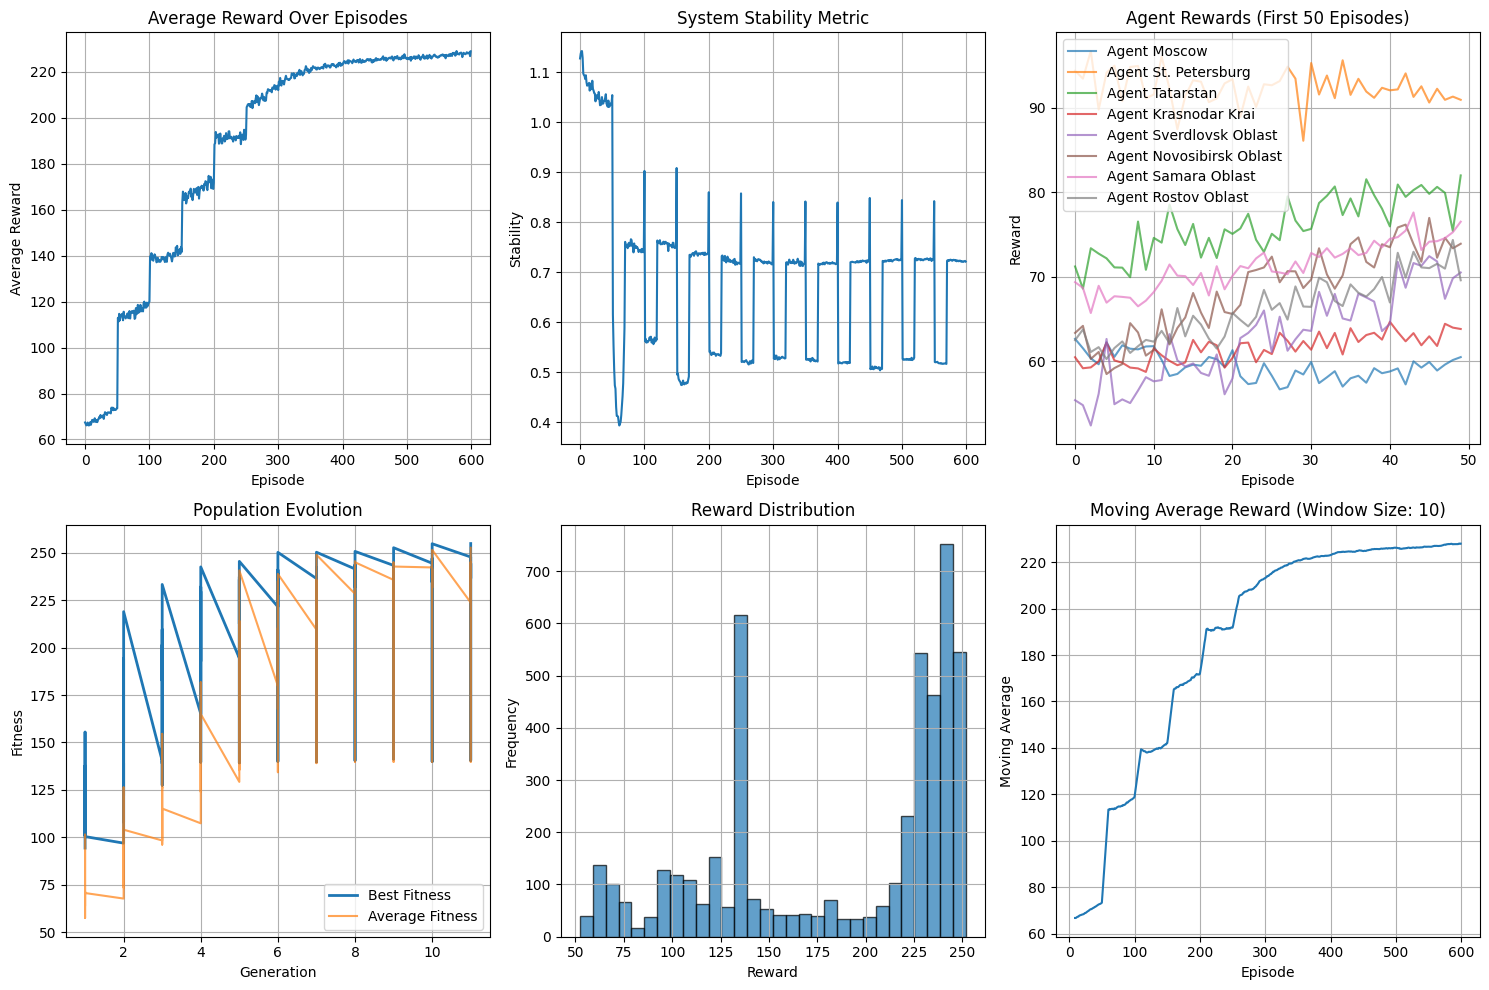

Results saved to maddpg-evo-0_results_20250913_172746.csv
--- EXPERIMENT 1: MADDPG ---
=== Starting Experiment: MADDPG ===
MADDPG - Episode 0, Avg Reward: 71.281, Stability: 0.851
MADDPG - Episode 20, Avg Reward: 71.739, Stability: 1.014
MADDPG - Episode 40, Avg Reward: 77.808, Stability: 0.953
MADDPG - Episode 60, Avg Reward: 81.963, Stability: 0.933
MADDPG - Episode 80, Avg Reward: 84.053, Stability: 0.931
MADDPG - Episode 100, Avg Reward: 88.977, Stability: 0.915
MADDPG - Episode 120, Avg Reward: 93.889, Stability: 0.894
MADDPG - Episode 140, Avg Reward: 96.673, Stability: 0.870
MADDPG - Episode 160, Avg Reward: 100.607, Stability: 0.854
MADDPG - Episode 180, Avg Reward: 105.874, Stability: 0.844
MADDPG - Episode 200, Avg Reward: 110.664, Stability: 0.834
MADDPG - Episode 220, Avg Reward: 113.674, Stability: 0.841
MADDPG - Episode 240, Avg Reward: 119.466, Stability: 0.822
MADDPG - Episode 260, Avg Reward: 123.878, Stability: 0.808
MADDPG - Episode 280, Avg Reward: 128.840, Stabilit

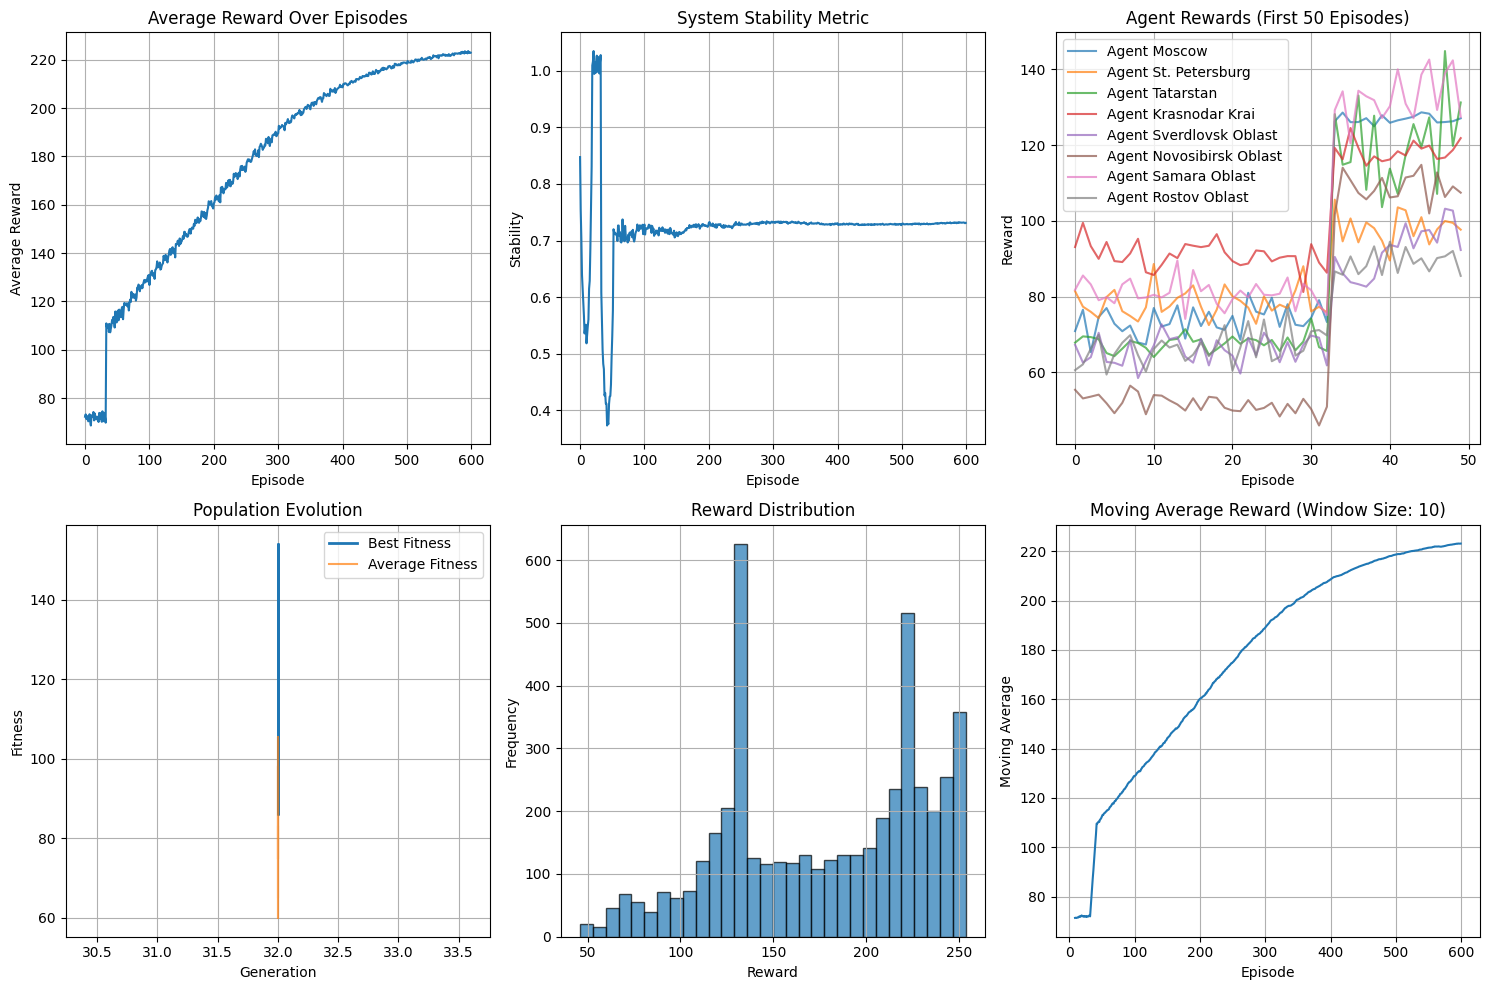

Results saved to maddpg-evo_results_20250913_174315.csv
--- EXPERIMENT 6: MAPPO-EVO ---
=== Starting Experiment: MAPPO-EVO ===
Training over 600 episodes. Adaptive evolution triggered upon stagnation (min_improvement=0.008).
MAPPO-EVO - Episode 0, Avg Reward: 66.657, Stability: 0.873
MAPPO-EVO - Episode 20, Avg Reward: 139.873, Stability: 0.408
MAPPO-EVO - Episode 40, Avg Reward: 158.916, Stability: 0.692
MAPPO-EVO - Episode 60, Avg Reward: 174.916, Stability: 0.733
MAPPO-EVO - Episode 80, Avg Reward: 172.382, Stability: 0.742
MAPPO-EVO - Adaptive evolutionary optimization at episode 84 (stagnation detected)
MAPPO-EVO - Episode 100, Avg Reward: 162.740, Stability: 0.421
MAPPO-EVO - Adaptive evolutionary optimization at episode 109 (stagnation detected)
MAPPO-EVO - Episode 120, Avg Reward: 171.788, Stability: 0.719
MAPPO-EVO - Episode 140, Avg Reward: 178.091, Stability: 0.735
MAPPO-EVO - Adaptive evolutionary optimization at episode 153 (stagnation detected)
MAPPO-EVO - Episode 160, Av

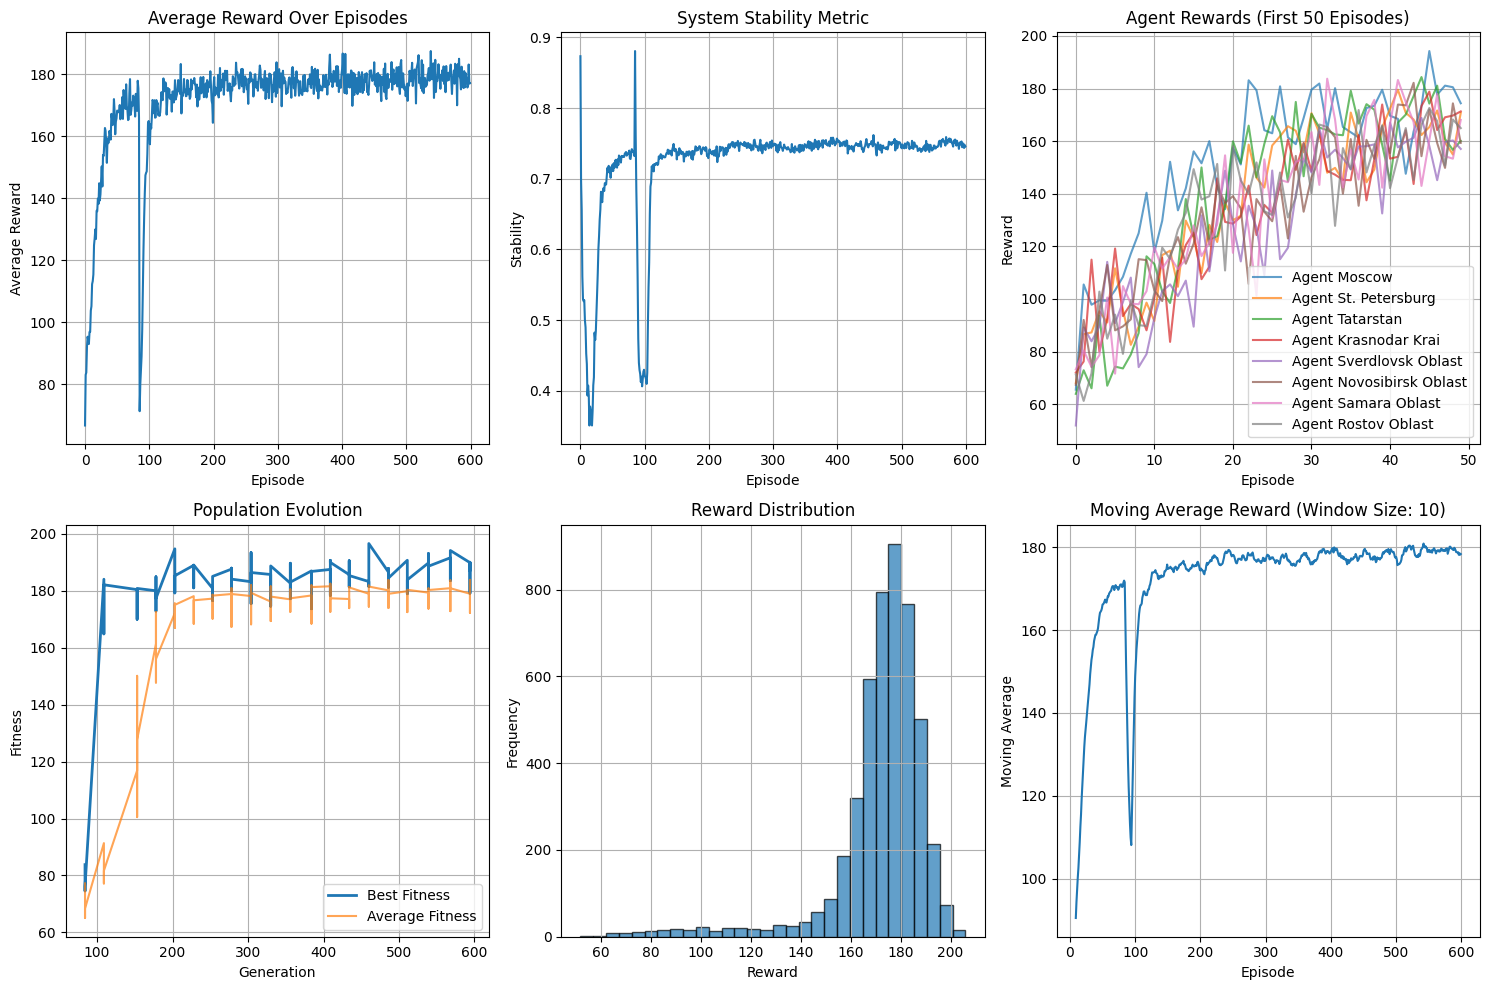

Results saved to mappo-evo_results_20250913_175516.csv
--- EXPERIMENT 7: MATD3-EVO ---
=== Starting Experiment: MATD3-EVO ===
Training over 600 episodes. Adaptive evolution triggered upon stagnation (min_improvement=0.008).
MATD3-EVO - Episode 0, Avg Reward: 68.726, Stability: 0.892
MATD3-EVO - Episode 20, Avg Reward: 68.225, Stability: 1.023
MATD3-EVO - Adaptive evolutionary optimization at episode 26 (stagnation detected)
MATD3-EVO - Episode 40, Avg Reward: 89.740, Stability: 0.726
MATD3-EVO - Episode 60, Avg Reward: 91.317, Stability: 0.893
MATD3-EVO - Adaptive evolutionary optimization at episode 61 (stagnation detected)
MATD3-EVO - Episode 80, Avg Reward: 106.332, Stability: 0.817
MATD3-EVO - Episode 100, Avg Reward: 107.642, Stability: 0.835
MATD3-EVO - Adaptive evolutionary optimization at episode 106 (stagnation detected)
MATD3-EVO - Episode 120, Avg Reward: 122.854, Stability: 0.702
MATD3-EVO - Adaptive evolutionary optimization at episode 132 (stagnation detected)
MATD3-EVO -

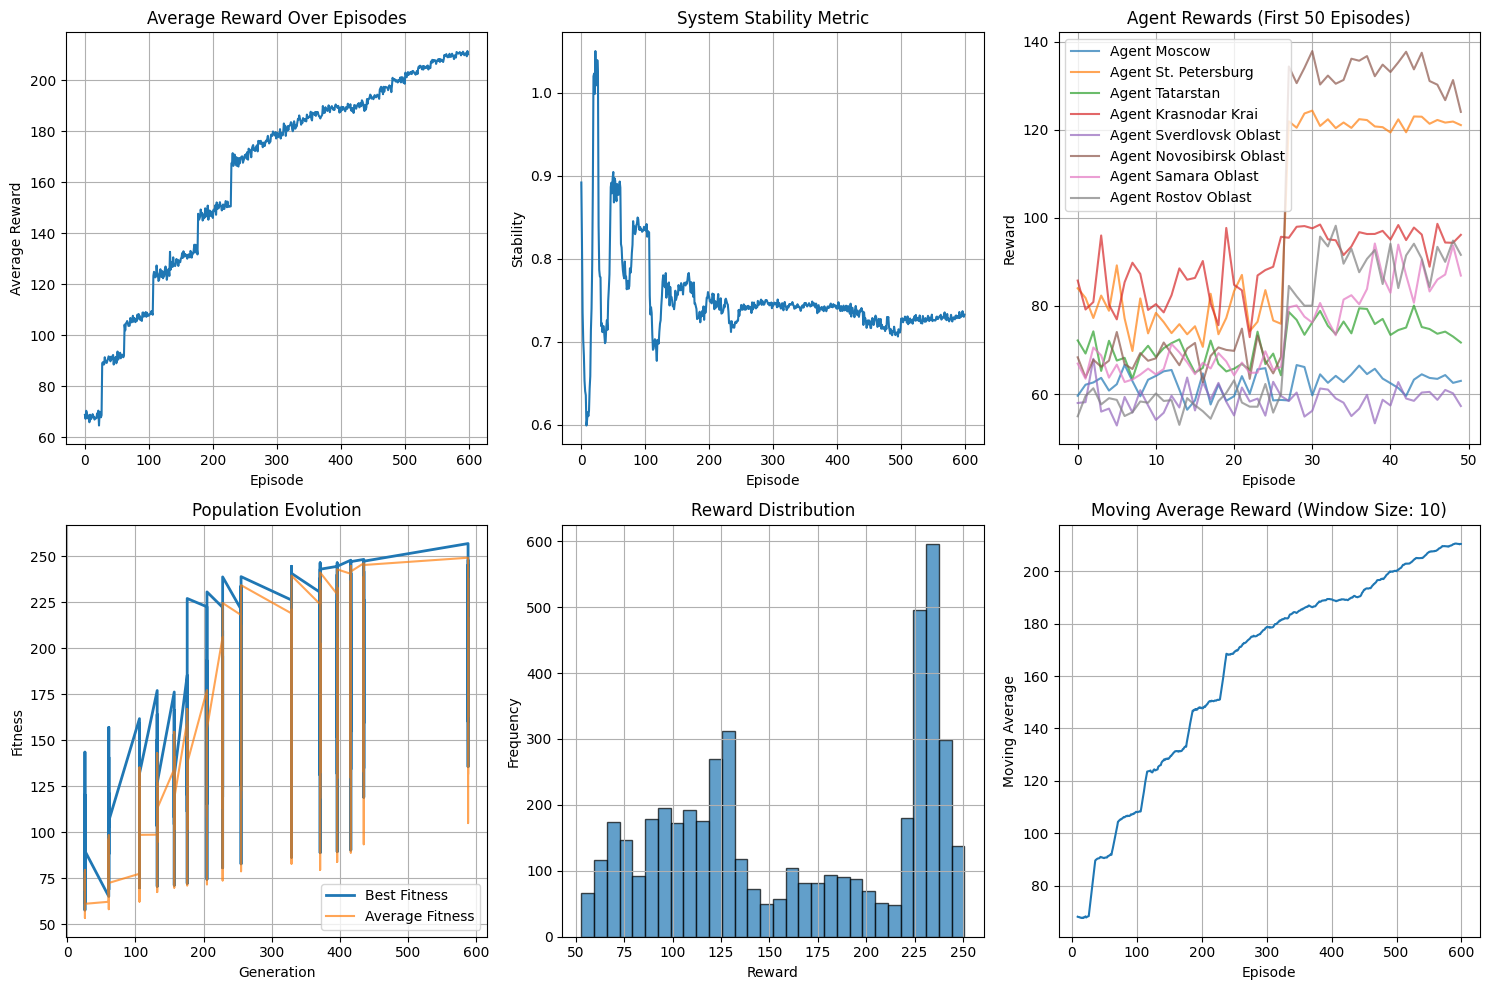

Results saved to matd3-evo_results_20250913_175903.csv
--- EXPERIMENT 8: MAAC-EVO ---
=== Starting Experiment: MAAC-EVO ===
Training over 600 episodes. Adaptive evolution triggered upon stagnation (min_improvement=0.008).
MAAC-EVO - Episode 0, Avg Reward: 71.541, Stability: 0.864
MAAC-EVO - Episode 20, Avg Reward: 71.394, Stability: 1.020
MAAC-EVO - Adaptive evolutionary optimization at episode 30 (stagnation detected)
MAAC-EVO - Episode 40, Avg Reward: 109.856, Stability: 0.601
MAAC-EVO - Episode 60, Avg Reward: 125.204, Stability: 0.758
MAAC-EVO - Episode 80, Avg Reward: 141.699, Stability: 0.760
MAAC-EVO - Episode 100, Avg Reward: 152.443, Stability: 0.766
MAAC-EVO - Episode 120, Avg Reward: 163.326, Stability: 0.752
MAAC-EVO - Episode 140, Avg Reward: 170.397, Stability: 0.751
MAAC-EVO - Episode 160, Avg Reward: 177.446, Stability: 0.746
MAAC-EVO - Episode 180, Avg Reward: 182.500, Stability: 0.735
MAAC-EVO - Episode 200, Avg Reward: 185.446, Stability: 0.738
MAAC-EVO - Episode 220

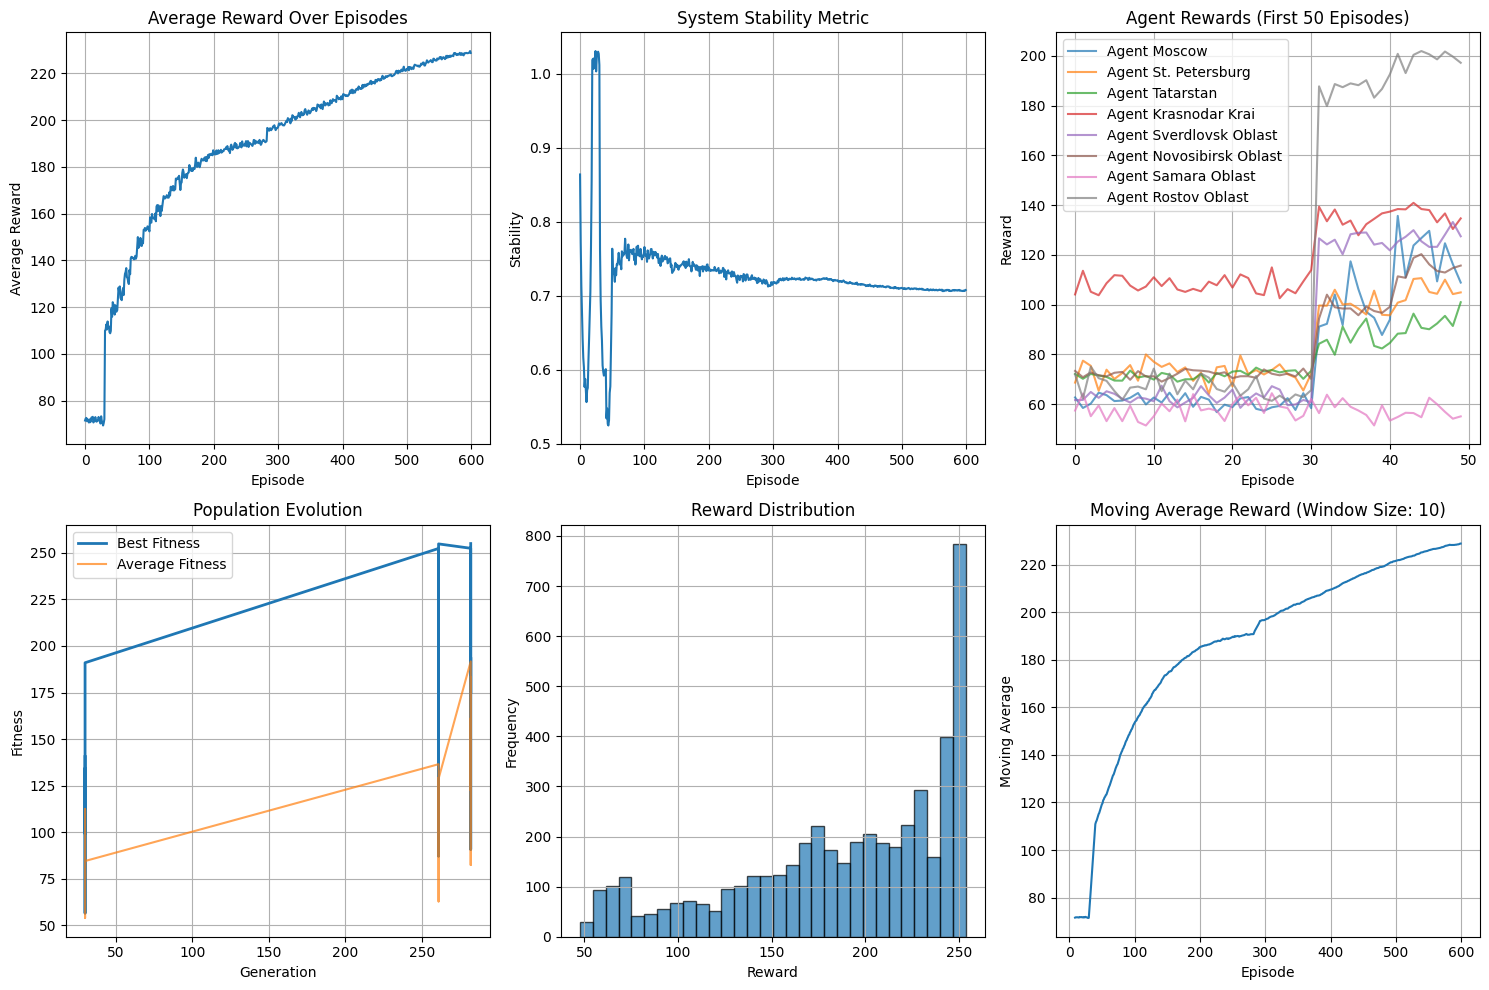

Results saved to maac-evo_results_20250913_180103.csv
=== ALL EXPERIMENTS COMPLETED ===
=== GENERATING COMPARATIVE RESULTS ===


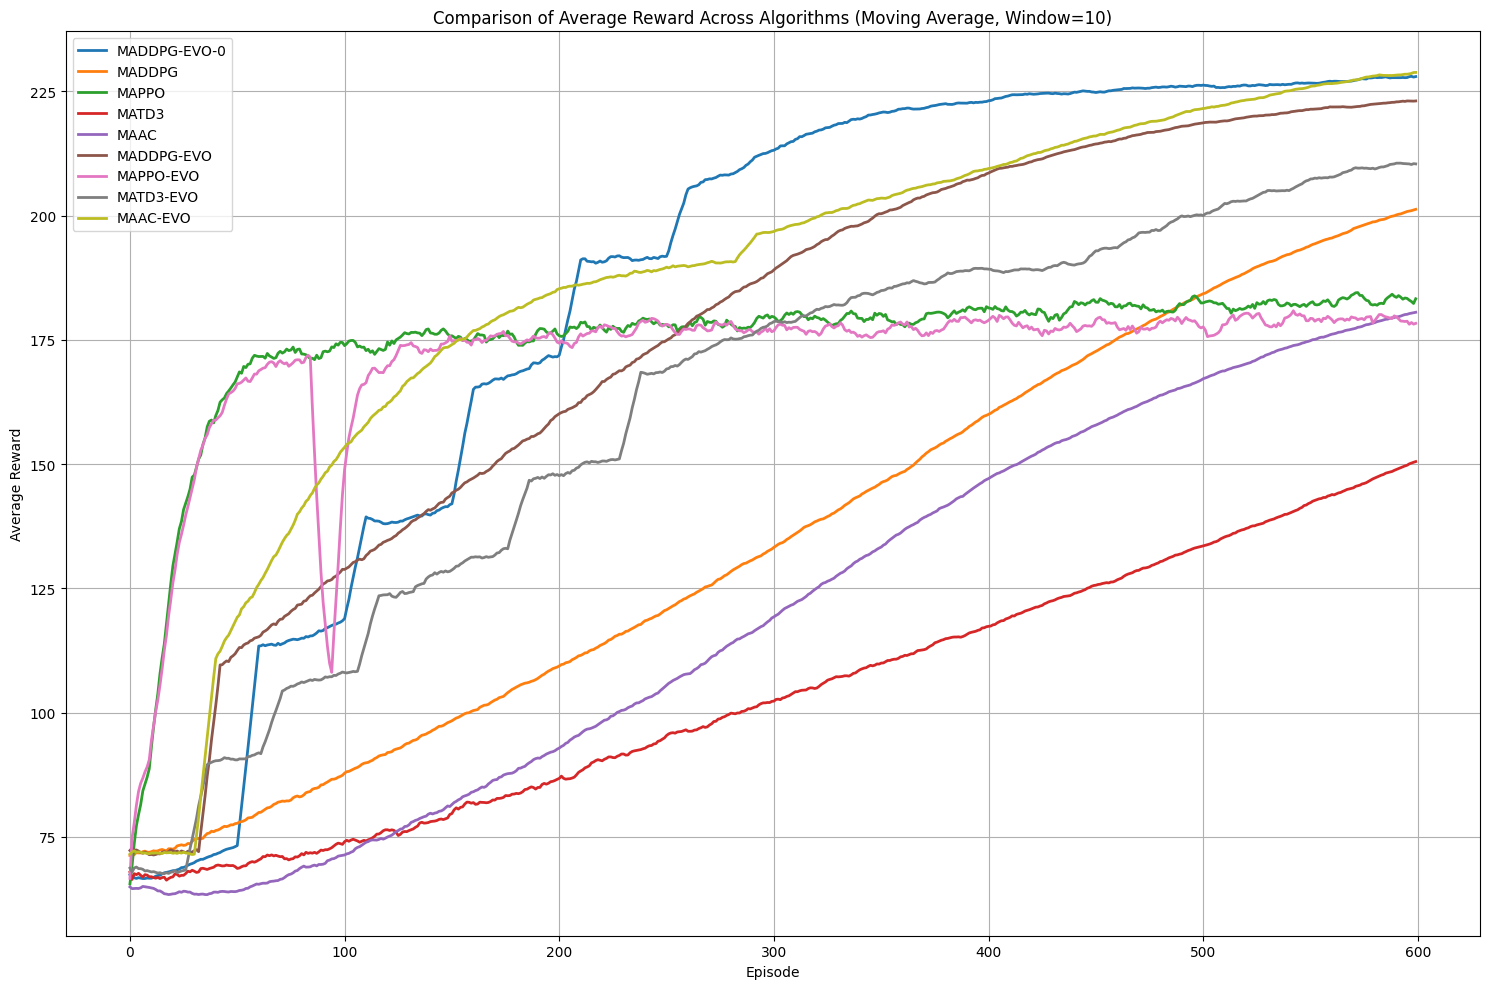

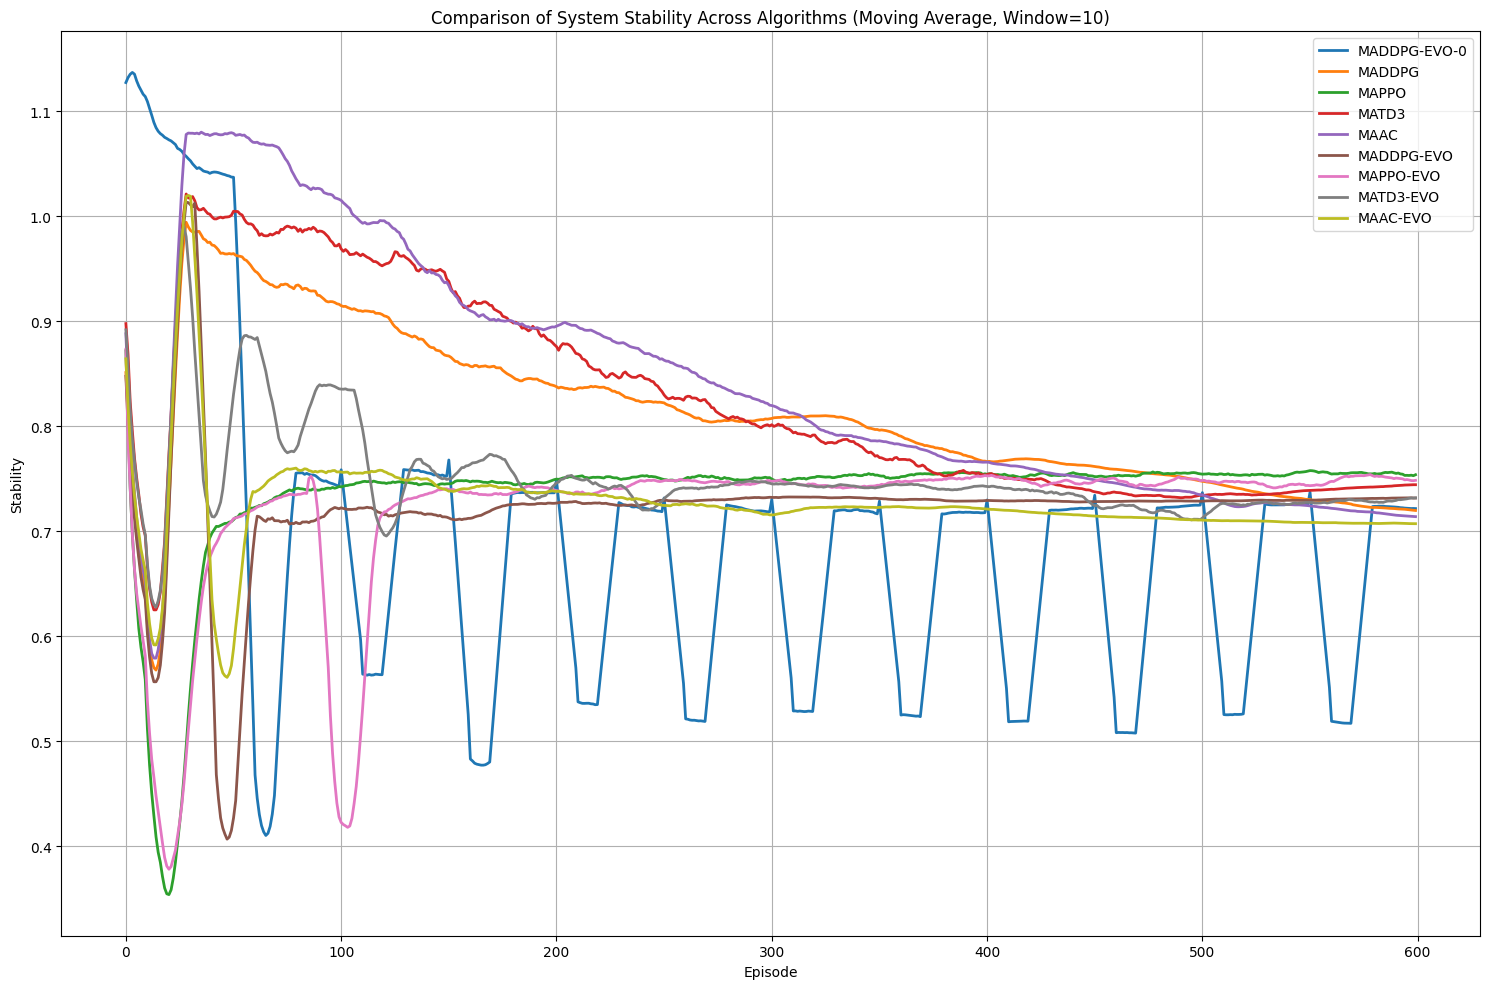

Summary Table of Results (averaged over final episodes):
   Algorithm Avg Reward (Final) Stability (Final) Max Reward Max Stability
MADDPG-EVO-0            227.882             0.722    228.975         1.142
      MADDPG            200.628             0.721    201.751         1.017
       MAPPO            183.536             0.755    191.790         0.872
       MATD3            149.637             0.744    152.131         1.048
        MAAC            180.036             0.715    180.958         1.093
  MADDPG-EVO            222.953             0.731    223.602         1.035
   MAPPO-EVO            179.091             0.749    187.480         0.881
   MATD3-EVO            210.421             0.730    211.426         1.050
    MAAC-EVO            228.529             0.707    229.572         1.031

Summary table saved to comparison_summary_20250913_180104.csv


In [50]:
# --- BLOCK 10: Main Execution Block ---
if __name__ == "__main__":
    print("=== STARTING ADDITIONAL EXPERIMENTS ===")
    # --- Data and Environment Preparation ---
    print("Loading and processing real-world data...")
    data_processor = DemographicDataProcessor(
        'regions_data_selective.csv',  # path to real data
        'crisis.txt'  # path to crisis scenarios
    )
    # CHANGED: Use data from 2000 onward
    years = list(range(2000, 2025))
    target_regions = ['Moscow', 'St. Petersburg', 'Tatarstan', 'Krasnodar Krai',
                     'Sverdlovsk Oblast', 'Novosibirsk Oblast', 'Samara Oblast', 'Rostov Oblast']
    training_data = data_processor.generate_training_data(years, target_regions, apply_crisis=True)
    print(f"Processed {len(training_data)} records for {len(target_regions)} regions")
    # --- Dictionary to store results of all experiments ---
    experiment_results = {}
    # --- Run Experiments ---
    # 0. MADDPG-EVO-0 (original, unchanged)
    print("--- EXPERIMENT 0: MADDPG-EVO-0 ---")
    env = DemographicEnvironment(training_data, n_regions=8, max_steps=50)
    agents_maddpg_evo_0, logger_maddpg_evo_0 = train_maddpg_with_evolution_original(env, n_episodes=600, evolution_frequency=50, population_size=8, experiment_name="MADDPG-EVO-0")
    experiment_results["MADDPG-EVO-0"] = logger_maddpg_evo_0
    # 1. MADDPG (improved)
    print("--- EXPERIMENT 1: MADDPG ---")
    env.reset()
    agents_maddpg, logger_maddpg = train_maddpg(env, n_episodes=600, experiment_name="MADDPG")
    experiment_results["MADDPG"] = logger_maddpg
    # 2. MAPPO (improved)
    print("--- EXPERIMENT 2: MAPPO ---")
    env.reset()
    agents_mappo, logger_mappo = train_mappo(env, n_episodes=600, experiment_name="MAPPO")
    experiment_results["MAPPO"] = logger_mappo
    # 3. MATD3 (improved)
    print("--- EXPERIMENT 3: MATD3 ---")
    env.reset()
    agents_matd3, logger_matd3 = train_matd3(env, n_episodes=600, experiment_name="MATD3")
    experiment_results["MATD3"] = logger_matd3
    # 4. MAAC (improved)
    print("--- EXPERIMENT 4: MAAC ---")
    env.reset()
    agents_maac, logger_maac = train_maac(env, n_episodes=600, experiment_name="MAAC")
    experiment_results["MAAC"] = logger_maac
    # 5. MADDPG-EVO (improved)
    print("--- EXPERIMENT 5: MADDPG-EVO ---")
    env.reset()
    agents_maddpg_evo, logger_maddpg_evo = train_maddpg_with_evolution(env, n_episodes=600, min_improvement=0.008, population_size=8, experiment_name="MADDPG-EVO")
    experiment_results["MADDPG-EVO"] = logger_maddpg_evo
    # 6. MAPPO-EVO (improved)
    print("--- EXPERIMENT 6: MAPPO-EVO ---")
    env.reset()
    agents_mappo_evo, logger_mappo_evo = train_mappo_with_evolution(env, n_episodes=600, min_improvement=0.008, population_size=8, experiment_name="MAPPO-EVO")
    experiment_results["MAPPO-EVO"] = logger_mappo_evo
    # 7. MATD3-EVO (improved)
    print("--- EXPERIMENT 7: MATD3-EVO ---")
    env.reset()
    agents_matd3_evo, logger_matd3_evo = train_matd3_with_evolution(env, n_episodes=600, min_improvement=0.008, population_size=8, experiment_name="MATD3-EVO")
    experiment_results["MATD3-EVO"] = logger_matd3_evo
    # 8. MAAC-EVO (improved)
    print("--- EXPERIMENT 8: MAAC-EVO ---")
    env.reset()
    agents_maac_evo, logger_maac_evo = train_maac_with_evolution(env, n_episodes=600, min_improvement=0.008, population_size=8, experiment_name="MAAC-EVO")
    experiment_results["MAAC-EVO"] = logger_maac_evo
    print("=== ALL EXPERIMENTS COMPLETED ===")
    # --- Comparative Analysis ---
    print("=== GENERATING COMPARATIVE RESULTS ===")
    # 1. Comparative plot: Average reward
    plt.figure(figsize=(15, 10))
    for name, logger in experiment_results.items():
        if 'episode' in logger.metrics and 'avg_reward' in logger.metrics:
            episodes = logger.metrics['episode']
            avg_rewards = logger.metrics['avg_reward']
            # Smooth
            if len(avg_rewards) > 10:
                moving_avg = pd.Series(avg_rewards).rolling(window=10, min_periods=1).mean()
                plt.plot(episodes, moving_avg, label=name, linewidth=2)
            else:
                plt.plot(episodes, avg_rewards, label=name, linewidth=2, marker='o', markersize=3)
    plt.title('Comparison of Average Reward Across Algorithms (Moving Average, Window=10)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # 2. Comparative plot: Stability metric
    plt.figure(figsize=(15, 10))
    for name, logger in experiment_results.items():
        if 'episode' in logger.metrics and 'stability' in logger.metrics:
            episodes = logger.metrics['episode']
            stability = logger.metrics['stability']
            if len(stability) > 10:
                moving_avg = pd.Series(stability).rolling(window=10, min_periods=1).mean()
                plt.plot(episodes, moving_avg, label=name, linewidth=2)
            else:
                plt.plot(episodes, stability, label=name, linewidth=2, marker='o', markersize=3)
    plt.title('Comparison of System Stability Across Algorithms (Moving Average, Window=10)')
    plt.xlabel('Episode')
    plt.ylabel('Stability')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # 3. Summary table of final results
    summary_data = []
    for name, logger in experiment_results.items():
        if 'avg_reward' in logger.metrics and 'stability' in logger.metrics:
            # Use last 20 episodes, or fewer if insufficient
            last_n = min(20, len(logger.metrics['avg_reward']))
            final_avg_reward = np.mean(logger.metrics['avg_reward'][-last_n:])
            final_stability = np.mean(logger.metrics['stability'][-last_n:])
            max_avg_reward = np.max(logger.metrics['avg_reward'])
            max_stability = np.max(logger.metrics['stability'])
            summary_data.append({
                'Algorithm': name,
                'Avg Reward (Final)': f"{final_avg_reward:.3f}",
                'Stability (Final)': f"{final_stability:.3f}",
                'Max Reward': f"{max_avg_reward:.3f}",
                'Max Stability': f"{max_stability:.3f}"
            })
    summary_df = pd.DataFrame(summary_data)
    print("Summary Table of Results (averaged over final episodes):")
    print(summary_df.to_string(index=False))
    # 4. Save summary table to CSV
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    summary_df.to_csv(f"comparison_summary_{timestamp}.csv", index=False)
    print(f"\nSummary table saved to comparison_summary_{timestamp}.csv")